
<h1><center>Evaluation of Popular Time Series Machine Learning Models</center></h1>
<h2><center> NUS Fintech Society 2019-2020 AY 1 Research Project</center></h2>
<h3><center>Group Member: Reon Ho, Samuel Khoo, Xiaohan SONG</center></h3>

## Aim of the Project:
Compare the impact of popular ML time series models (trees, prophet, LSTM, SVM) in stock price prediction and trend signal classification. 

# Section 1: LSTM and SVM model
By SONG Xiaohan

Reference:
https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944<br>
https://github.com/DarkKnight1991/Stock-Price-Prediction<br>
Apple News:
https://www.apple.com/newsroom/archive/?page=2 <br>
Output:<br>
RMSE of Adjust close prediction<br>
Down/up prediction: confusion matrix , ROC<br>
Leading days: 3-day ahead

<h3>Train: 01/09/2015 to 31/08/2018</h3>
<h3>Test: 01/09/2018 to 31/08/2019</h3>





<h1> INTRODUCTION </h1>
 <h5>Stock price is one of the most classic temporal distributed data, and the long short term memory(LSTM), a kind of advanced recurrent neural network(RNN)is a typical deep learning algorithm targeting at temporal distribution data, so in this notebook, it is used to process Apple stock price data, and the result will be compared with other two ML methods.</h5>
 <br>
 <br>
<h1> OVERALL LOGIC</h1> 
<h4>1. Predict stock price by training OHCLV data with a LSTM regression model.</h4>

<h4>2. Predict stock price trend (up or down or uncertain) by training OHCLV data with a LSTM classification model.</h4>
 
<h4>3. Since the outcome of LSTM classification model was really bad, alternatively, an SVM classification model was built to predict stock price trend (up or down or uncertain) by training OHCLV data.</h4>
<br>
<br>
<h1>CONTENTS</h1>
<h3>1. Preliminary data analysis</h3>
<br>
<h3>2. Data Processing</h3>
    <h4> 2.1 Construct binary signal data for classification </h4>
    <h4> 2.2 Split data into windows (considering windowsize and leading day) </h4>
    <h4> 2.3 Identify taining, validation and testing datasets </h4>
    <br>
<h3>3. LSTM Regression model<h3>
    <h4>3.1 Construct model </h4>
    <h4>3.2 Evaluate and tuning model on the validation set</h4>
    <h4>3.3 Test model on the testing set </h4>
    <br>
<h3>4. LSTM Classification model<h3>
    <h4>4.1 Construct model </h4>
    <h4>4.2 Evaluate and tuning model on the validation set</h4>
<h3>5. SVM classification model<h3>
    <br>
     <h4>5.1 Construct model </h4>
     <h4>5.2 Evaluate and tuning model on the validation set</h4>
     <h4>5.3 Test model on the testing set </h4>
    <br>
<h3>6. Conclusion<h3>

# Start form importing packages

In [87]:
import pandas as pd
import pandas_datareader.data as web   
import datetime
import matplotlib.pyplot as plt   # Import matplotlib
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import merge, Input, concatenate, average, add
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses
from keras import optimizers
from sklearn import svm
import os
import pickle
from sklearn.multiclass import OneVsRestClassifier

import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging


#for ROC plot and confusion matrix
import numpy as np
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

# Preliminary data analysis

In [2]:
start_train=datetime.datetime(2015, 9, 1)
end_train=datetime.datetime(2018, 8, 31)
start_test=datetime.datetime(2018, 9, 1)
end_test=datetime.datetime(2019, 8, 31)
apple_train=web.get_data_yahoo('AAPL',start_train,end_train)
apple_test=web.get_data_yahoo('AAPL',start_test,end_test)
apple_train
apple_test
	
print(len(apple_train))
print(len(apple_test))
apple_train.tail()


758
251


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-08-27,218.740005,216.330002,217.149994,217.940002,20525100.0,214.609741
2018-08-28,220.539993,218.919998,219.009995,219.699997,22776800.0,216.342850
2018-08-29,223.490005,219.410004,220.149994,222.979996,27254800.0,219.572723
2018-08-30,228.259995,222.399994,223.250000,225.029999,48793800.0,221.591385
2018-08-31,228.869995,226.000000,226.509995,227.630005,43340100.0,224.151657


<h5>We can see, there are 758 days in the training set, 251 days in the testing set. Now, we see how they look on plots:</h5>

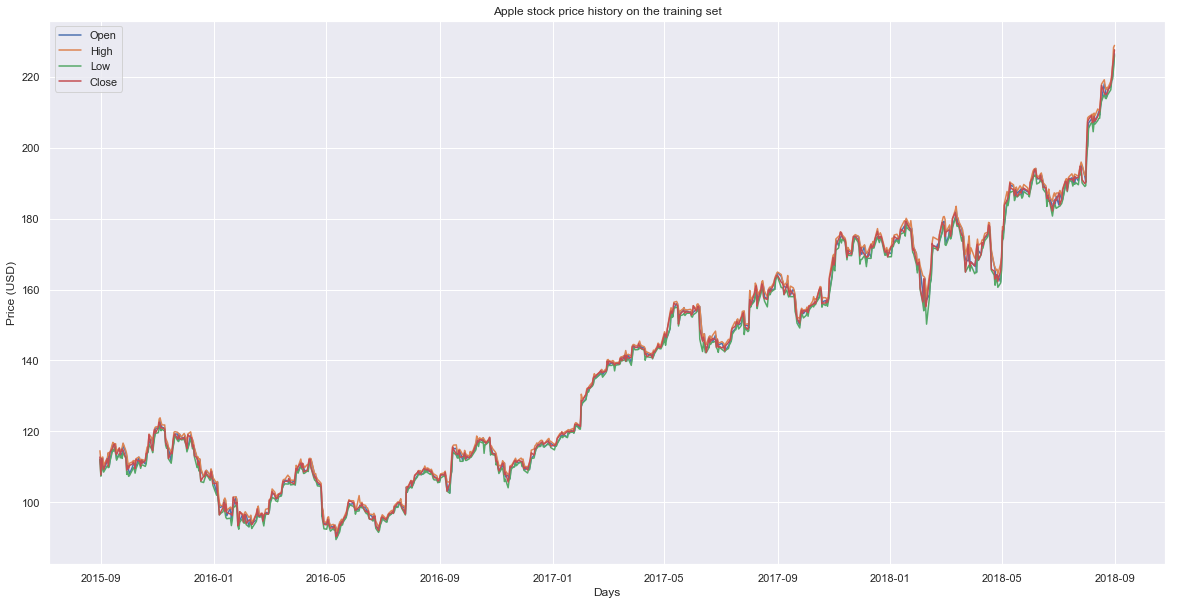

In [202]:
plt.figure()
plt.plot(apple_train["Open"])
plt.plot(apple_train["High"])
plt.plot(apple_train["Low"])
plt.plot(apple_train["Close"])
plt.title('Apple stock price history on the training set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

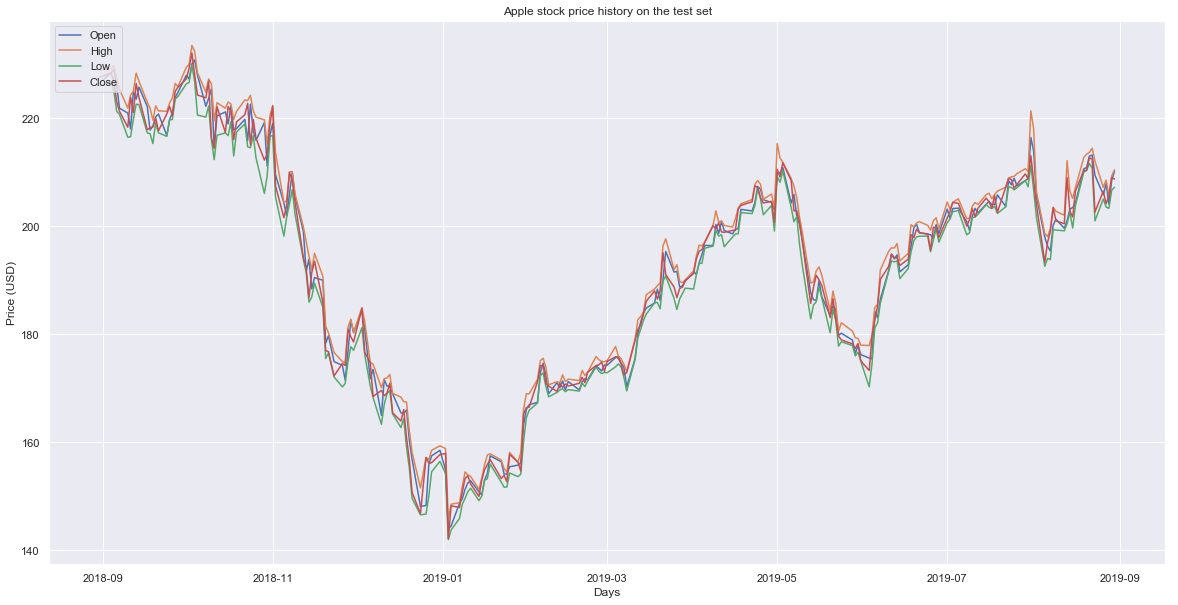

In [201]:
plt.figure()
plt.plot(apple_test["Open"])
plt.plot(apple_test["High"])
plt.plot(apple_test["Low"])
plt.plot(apple_test["Close"])
plt.title('Apple stock price history on the test set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

<h5>We can see from the plot, there is no big difference between "open", "high", "close", "low" price. Now let’s check out the plot for volume :</h5>

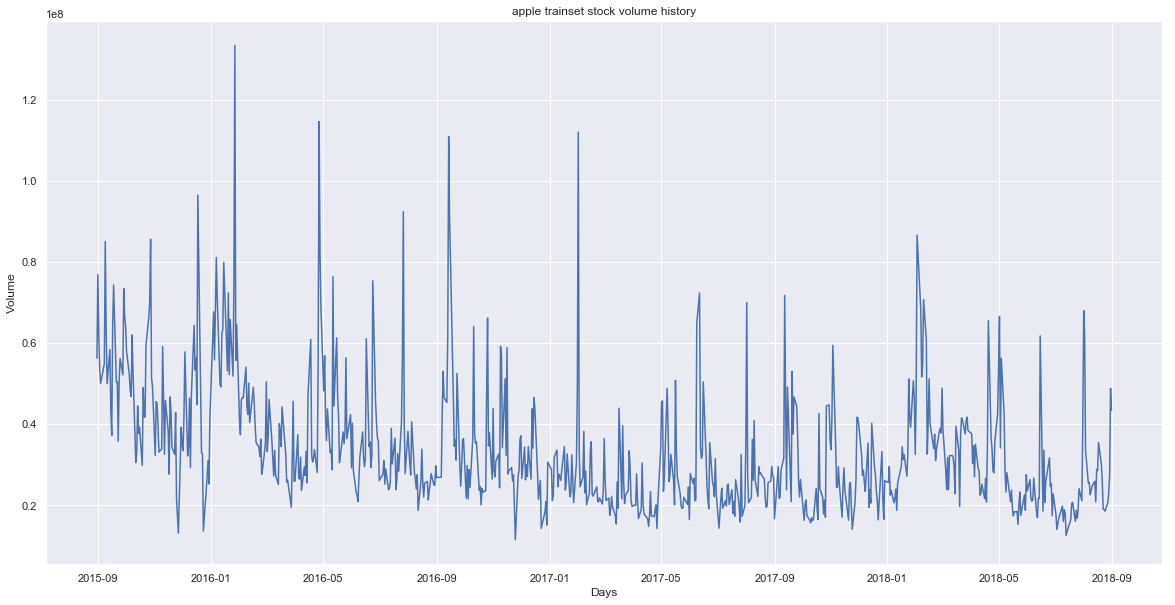

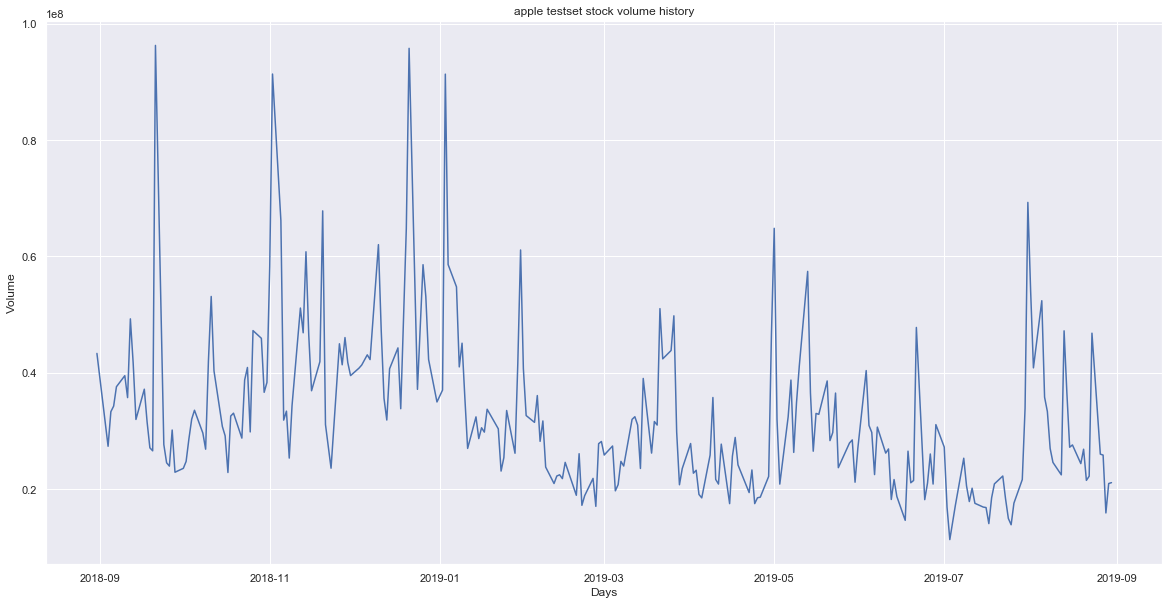

In [204]:
plt.figure()
plt.plot(apple_train["Volume"])
plt.title('apple trainset stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

plt.figure()
plt.plot(apple_test["Volume"])
plt.title('apple testset stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

<h5>There is a little surge in the number of transactions around 201509--201701 in the training set and 201809--201901 on the timeline, which happens to coincide with the significant fluctuations or sudden drop of stock price. May be we can go back to that particular date and dig up old news articles to find what caused it.</h5>

<h5>Now let’s see if we have any null/Nan values to worry about. As it turns out we don’t have any null values. </h5>

In [6]:
print("checking if any null values are present\n", apple_train.isna().sum())
print("checking if any null values are present\n", apple_test.isna().sum())

checking if any null values are present
 High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
checking if any null values are present
 High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


# Data Processing

## Normalizing the data

The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. Here we use MinMaxScaler from Sci-kit Learn. But before that we have to split the dataset into training and testing datasets. Also I will convert the DataFrame to ndarray in the process.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
train_cols = ["Open","High","Low","Close","Volume"]
test_cols = ["Open","High","Low","Close","Volume"]
# scale the feature MinMax, build array
x_train = apple_train.loc[:,train_cols].values
x_test= apple_test.loc[:,test_cols].values
min_max_scaler = MinMaxScaler()
#scale the training and the testing set
#transform the maximum value to 1, the minimum value to 0 and convert the remaining numbers proportionally 
x_train_scale = min_max_scaler.fit_transform(x_train)
x_test_scale = min_max_scaler.transform(apple_test.loc[:,test_cols])
print(x_test_scale)
print(x_train_scale)

[[1.         1.         1.         1.         0.26140952]
 [1.01391846 1.00225946 1.00461441 1.00531718 0.13055791]
 [1.01816725 1.00583093 0.99340809 0.9944642  0.17931265]
 ...
 [0.83583628 0.83126826 0.83388272 0.83902684 0.03661302]
 [0.86806831 0.85750737 0.85834618 0.86437461 0.07805647]
 [0.88022862 0.86574345 0.8623013  0.86240805 0.07931084]]
[[0.16138012 0.16661808 0.16501867 0.16330399 0.36715075]
 [0.14760825 0.1473032  0.13103347 0.12659337 0.53628651]
 [0.1481943  0.15065597 0.14399763 0.16024473 0.41358051]
 ...
 [0.95341    0.96078725 0.95173225 0.96613003 0.12944793]
 [0.976119   0.99555393 0.97363212 0.98106194 0.30615093]
 [1.         1.         1.         1.         0.26140952]]


## Build timeseries windows
Time_step is the time period of data used as input at each time;<br>
    Leading_days is the number of days ahead of the predicted day;<br>
    Features is the number of attributes used to represent each time step. Here if we use OHCLV values for prediction, then the feature number should be 5 .

In [101]:
def build_timeseries(mat, y_col_index, TIME_STEPS, LEADING_DAYS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS-LEADING_DAYS
    dim_0 = mat.shape[0] - TIME_STEPS-LEADING_DAYS #number of time-series samples 
    dim_1 = mat.shape[1]# number of features
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(0,dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+LEADING_DAYS+i, y_col_index]#‘y_col_index’ is the index of your output column
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

 Now suppose after converting data into supervised learning format, we will have to trim your training set to remove the odd samples left out so that the batches could be devided properly. 
 Here, batch_size is the scale of data we use to update the weights once. 

In [102]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size 
    #here the input 'mat' should be the overall input time series data which has already been devided into windows 
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

### Create functions for turning price vector to signal vector

In [103]:
def turn_to_signal(vec):
    y = np.zeros(len(vec)-1)
    z = np.zeros(len(vec)-1)#return
    x = np.zeros([len(vec)-1,3])
    
    for i in range(0,len(vec)-1):
        y[i] = np.sign(vec[i+1]-vec[i])
        z[i]=vec[i+1]-vec[i]
        if (z[i]>0.005):#increase
            x[i,0]=1
        else:
            if (np.abs(z[i])<=0.005):#noise
                x[i,1]=1
            else:
                x[i,2]=1
    return  y,x

An example:

In [104]:
print(turn_to_signal([0.001,0.004,0.15,0.102])[0])
print(turn_to_signal([0.001,0.004,0.15,0.102])[1])


[ 1.  1. -1.]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


Now using the above functions lets form our train, validation and test datasets.

In [172]:
BATCH_SIZE=20
TIME_STEPS=30
LEADING_DAYS=3
OUTPUT_PATH="C:\\Users\Lenovo X240\\Documents\\Fintech\\8 weeks research"
epoch=50
lr=0.01
x_t, y_t = build_timeseries(x_train_scale, 3, TIME_STEPS, LEADING_DAYS)#data for train
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test_scale, 3,30,3)# x_temp contains the data for validation as well as for test
x_val, x_test_t = np.split(trim_dataset(x_temp,BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
Date_train=apple_train.index
Date_test=apple_test.index
Date_val, Date_test = np.split(trim_dataset(Date_test, BATCH_SIZE),2)
#create set for signal classifier
y_t_sig=turn_to_signal(y_t)[0]
y_val_sig=turn_to_signal(y_val)[0]
y_test_sig=turn_to_signal(y_test_t)[0]



length of time-series i/o (725, 30, 5) (725,)
length of time-series i/o (218, 30, 5) (218,)


### Creating model for price prediction
We will be using LSTM for this task, which is a variation of Recurrent Neural Network. Creating LSTM model is as simple as this:

In [161]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

As for finding the most proper tunning parameters, we will explore later.

In [162]:
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 720 samples, validate on 100 samples
Epoch 1/50
2s - loss: 0.0753 - val_loss: 0.0560
Epoch 2/50
0s - loss: 0.0281 - val_loss: 0.0853
Epoch 3/50
0s - loss: 0.0245 - val_loss: 0.0544
Epoch 4/50
0s - loss: 0.0240 - val_loss: 0.0922
Epoch 5/50
0s - loss: 0.0252 - val_loss: 0.0622
Epoch 6/50
0s - loss: 0.0238 - val_loss: 0.0880
Epoch 7/50
0s - loss: 0.0220 - val_loss: 0.0860
Epoch 8/50
0s - loss: 0.0189 - val_loss: 0.0441
Epoch 9/50
0s - loss: 0.0114 - val_loss: 0.0476
Epoch 10/50
0s - loss: 0.0110 - val_loss: 0.0468
Epoch 11/50
0s - loss: 0.0081 - val_loss: 0.0485
Epoch 12/50
0s - loss: 0.0069 - val_loss: 0.0444
Epoch 13/50
0s - loss: 0.0070 - val_loss: 0.0348
Epoch 14/50
0s - loss: 0.0057 - val_loss: 0.0350
Epoch 15/50
0s - loss: 0.0058 - val_loss: 0.0293
Epoch 16/50
0s - loss: 0.0055 - val_loss: 0.0256
Epoch 17/50
0s - loss: 0.0055 - val_loss: 0.0264
Epoch 18/50
0s - loss: 0.0059 - val_loss: 0.0189
Epoch 19/50
0s - loss: 0.0056 - val_loss: 0.0140
Epoch 20/50
0s - loss: 0.0049 - 

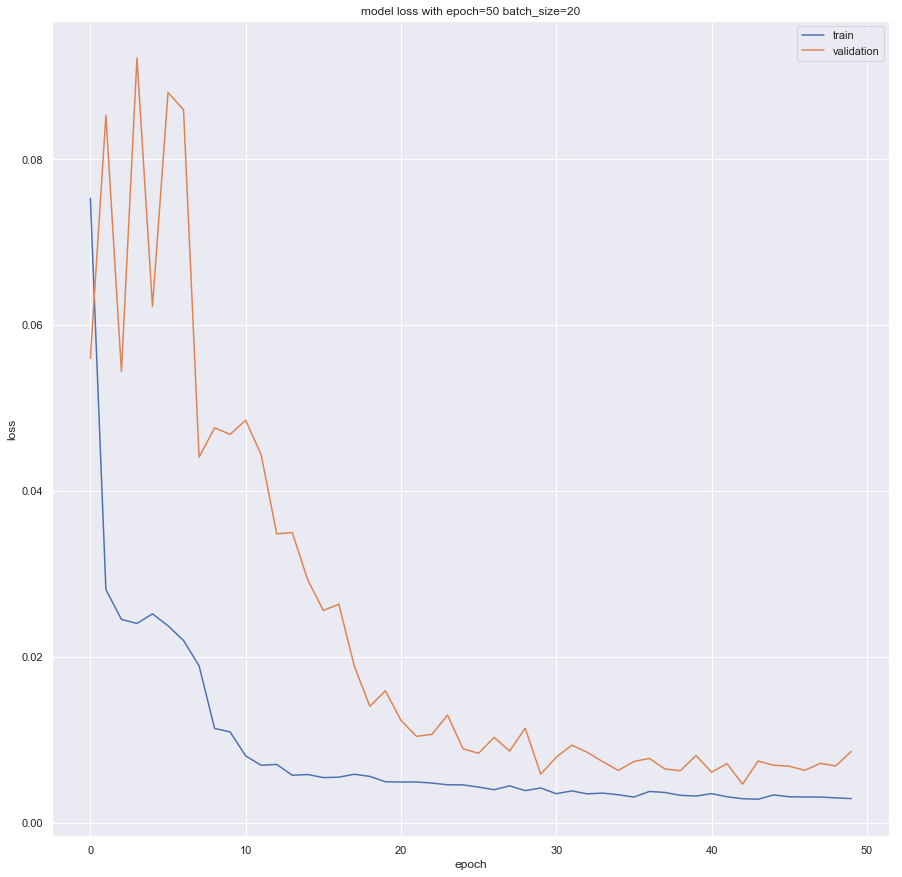

In [163]:
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with epoch=50 batch_size=20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

### Evaluate price prediction model on validation set

Error is 0.008604648815567445 (100,) (100, 1)


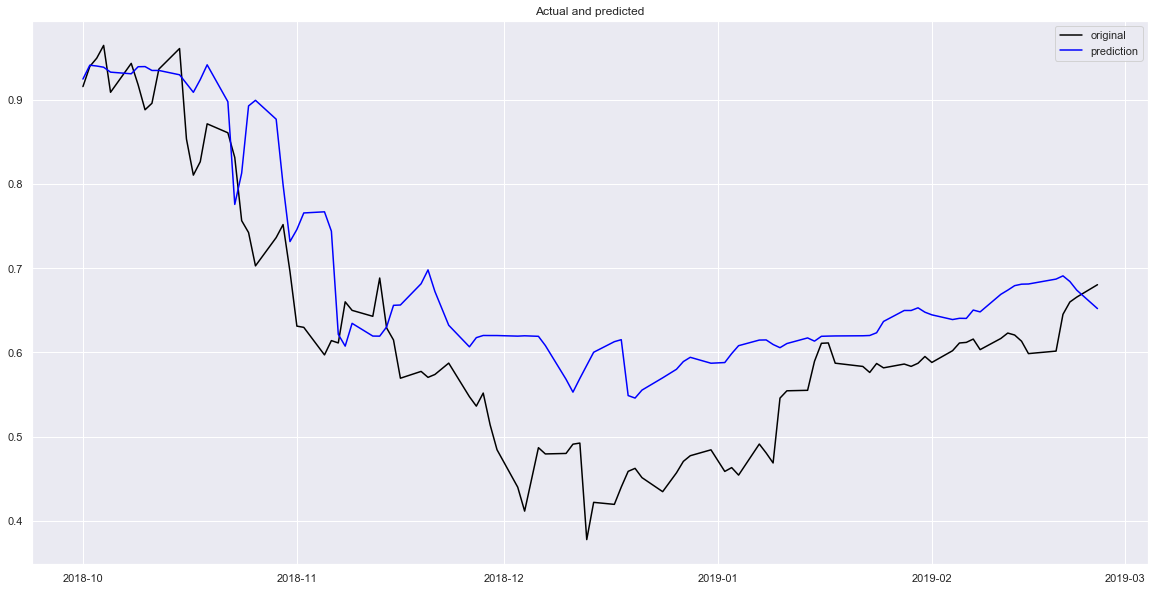

In [175]:
#test the accuraccy of the model
pred = lstm_model.predict(trim_dataset(x_val,BATCH_SIZE), batch_size=BATCH_SIZE)
Date_val=pd.to_datetime(Date_val.date)[-len(pred):]
predicted = pred
original = y_val
error = mean_squared_error(original, predicted)
print("Error is", error, original.shape, predicted.shape)
plt.title('Actual and predicted')
plt.plot(Date_val,original, color='black', label = 'Original data')
plt.plot(Date_val,pred, color='blue', label = 'Predicted data')
plt.legend(['original', 'prediction'],loc='best')
plt.show()

### Creating model for signal classifier


In [178]:
lstm_class_model = Sequential()
lstm_class_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_class_model.add(Dropout(0.25))
#lstm_class_model.add(Dense(20,activation='relu'))
lstm_class_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_class_model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [179]:
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_class_model.fit(trim_dataset(x_t[0:len(x_t)-1], BATCH_SIZE), trim_dataset(y_t_sig, BATCH_SIZE), epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val[0:len(x_val)-1], BATCH_SIZE),
                    trim_dataset(y_val_sig, BATCH_SIZE)), callbacks=[csv_logger])

Train on 700 samples, validate on 80 samples
Epoch 1/50
2s - loss: 0.4562 - val_loss: 0.0048
Epoch 2/50
0s - loss: 0.2488 - val_loss: 0.0207
Epoch 3/50
0s - loss: 0.2430 - val_loss: 0.0291
Epoch 4/50
0s - loss: 0.2230 - val_loss: 0.0316
Epoch 5/50
0s - loss: 0.2221 - val_loss: 0.0317
Epoch 6/50
0s - loss: 0.2100 - val_loss: 0.0302
Epoch 7/50
0s - loss: 0.2122 - val_loss: 0.0267
Epoch 8/50
0s - loss: 0.2272 - val_loss: 0.0313
Epoch 9/50
0s - loss: 0.2157 - val_loss: 0.0288
Epoch 10/50
0s - loss: 0.2558 - val_loss: 0.0296
Epoch 11/50
0s - loss: 0.1950 - val_loss: 0.0255
Epoch 12/50
0s - loss: 0.2249 - val_loss: 0.0245
Epoch 13/50
0s - loss: 0.2378 - val_loss: 0.0283
Epoch 14/50
0s - loss: 0.2066 - val_loss: 0.0260
Epoch 15/50
0s - loss: 0.1755 - val_loss: 0.0265
Epoch 16/50
0s - loss: 0.2190 - val_loss: 0.0270
Epoch 17/50
0s - loss: 0.2119 - val_loss: 0.0282
Epoch 18/50
0s - loss: 0.2393 - val_loss: 0.0318
Epoch 19/50
0s - loss: 0.2000 - val_loss: 0.0341
Epoch 20/50
0s - loss: 0.1712 - v

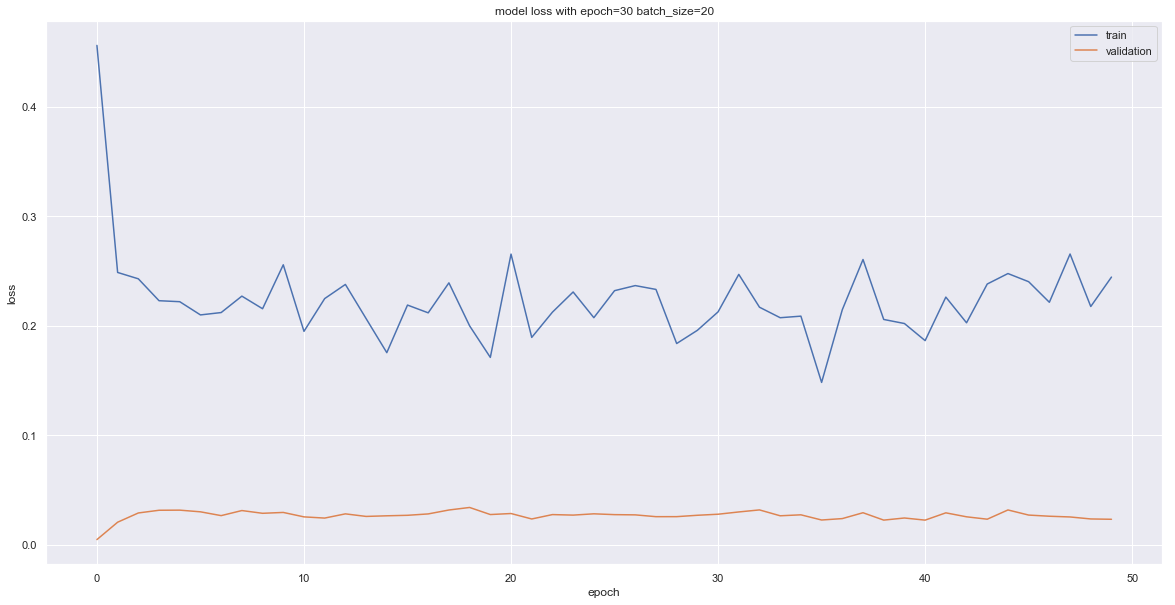

In [180]:
#test the accuraccy of the model
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with epoch=30 batch_size=20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Problem occurs!

### Evaluate  signal classifier model on validation set

In [181]:
pred_signal = lstm_class_model.predict(trim_dataset(x_val[0:len(x_val)-1],BATCH_SIZE), batch_size=BATCH_SIZE)

predicted_sig =pred_signal
original_sig = y_val_sig
print(predicted_sig[:10])

[[0.02308851]
 [0.02308851]
 [0.02308851]
 [0.02308851]
 [0.02308851]
 [0.02308851]
 [0.02308851]
 [0.02308851]
 [0.02308851]
 [0.02308851]]


Tragedy!<br>
### Try SVM for classification Instead.

In [182]:
#create set for signal classifier, again
y_t_sig=turn_to_signal(y_t)[1]
y_val_sig=turn_to_signal(y_val)[1]
y_test_sig=turn_to_signal(y_test_t)[1]
print(sum(y_t_sig))

[231. 304. 184.]


reshape the data set for fitting the model

In [183]:
x_sig_t=x_t[0:len(x_t)-1]
x_sig_val=x_val[0:len(x_val)-1]
nsamples, nx, ny = x_sig_t.shape
x_sig_t =x_sig_t.reshape((nsamples,nx*ny))
nsamples1, nx1, ny1 = x_sig_val.shape
x_sig_val =x_sig_val.reshape((nsamples1,nx1*ny1))

Build the model

In [184]:
random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel='poly', probability=True,
                                 random_state=random_state))# kernel must be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
y_pre = classifier.fit(x_sig_t, y_t_sig).decision_function(x_sig_val)
y_pre[1:10]

class_pre=y_pre.argmax(axis=1)
class_org=y_val_sig.argmax(axis=1)

C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [185]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_sig[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_sig.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

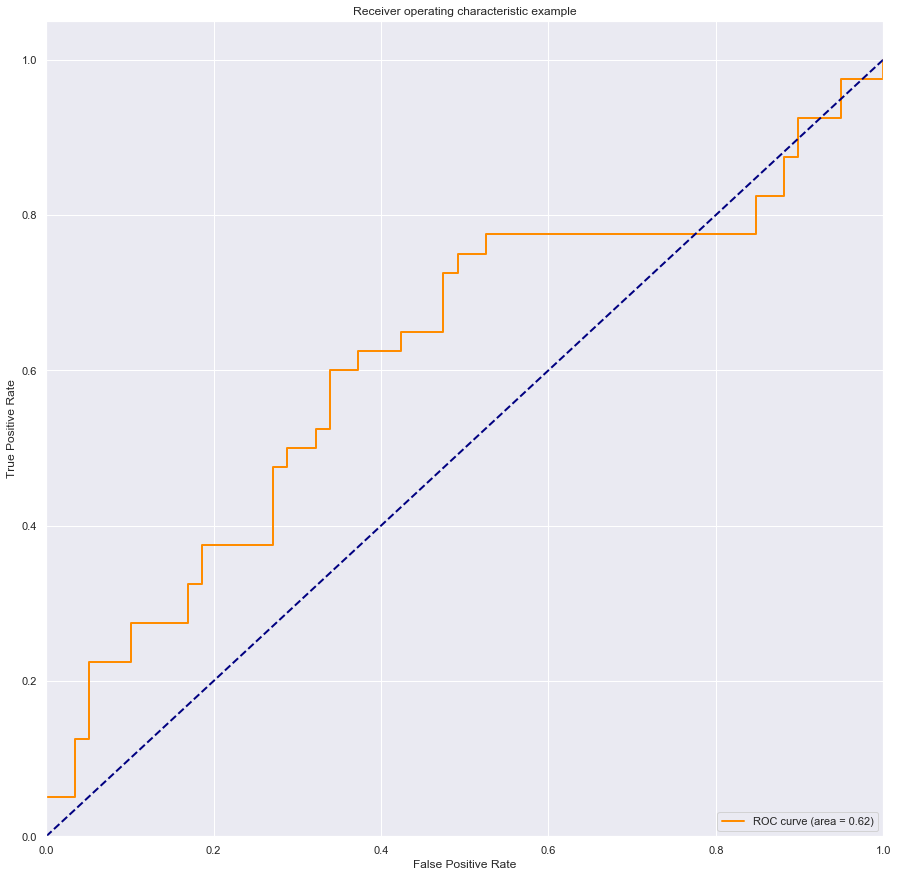

In [186]:
plt.figure(figsize=(15,15))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Seeems much better, next we calculate the confusion matrix.

In [187]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[26 12  3]
 [10  4  4]
 [29  9  2]]
Normalized confusion matrix
[[0.63414634 0.29268293 0.07317073]
 [0.55555556 0.22222222 0.22222222]
 [0.725      0.225      0.05      ]]


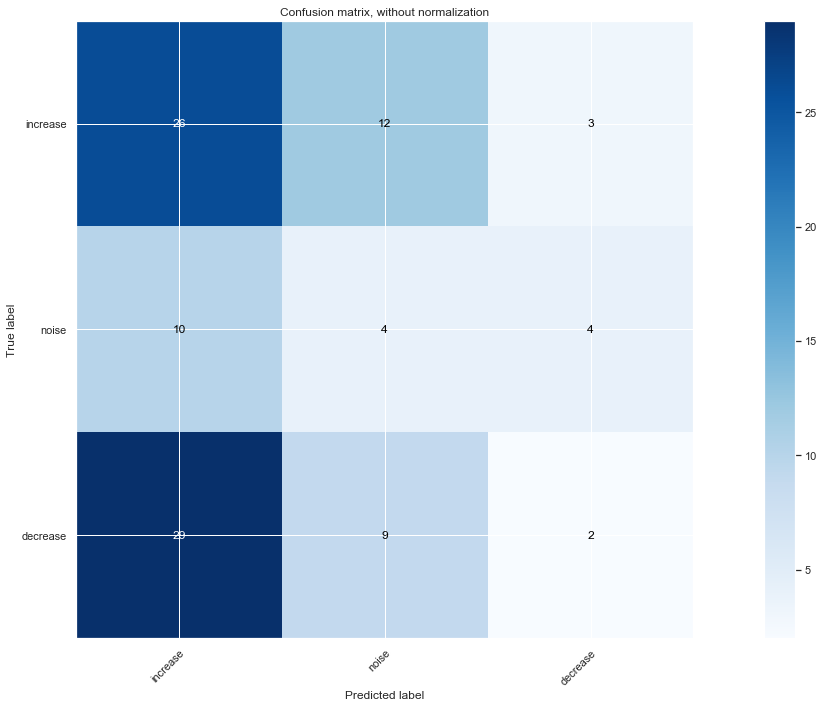

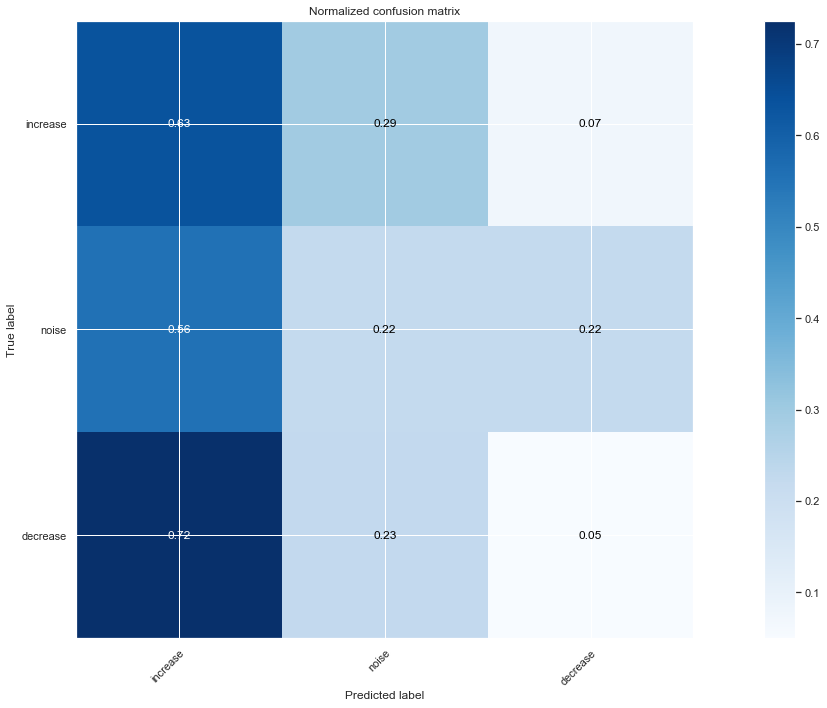

In [188]:
class_names=np.array(['increase', 'noise', 'decrease'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### From the confusion matrix, we could see, although the ROC was relatively satisfactory, the false positive rate of prediction was relatively high.

## For test set

Previously, we built model on the training data set and did prediction on the validation set. Now, we need to update the model and add validation data as training input.

In [189]:
BATCH_SIZE=20
TIME_STEPS=30
LEADING_DAYS=3
OUTPUT_PATH="C:\\Users\Lenovo X240\\Documents\\Fintech\\8 weeks research"
epoch=50
lr=0.01
x_t, y_t = build_timeseries(x_train_scale, 3, TIME_STEPS, LEADING_DAYS)#data for train
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test_scale, 3,30,3)# x_temp contains the data for validation as well as for test
x_val, x_test_t = np.split(trim_dataset(x_temp,BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
x_t=np.vstack((x_t,x_val))#undate the training set
y_t=np.hstack((y_t,y_val))#update the training set


length of time-series i/o (725, 30, 5) (725,)
length of time-series i/o (218, 30, 5) (218,)


Now we retrain the model:

In [190]:
lstm_model_new = Sequential()
lstm_model_new.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model_new.add(Dropout(0.5))
lstm_model_new.add(Dense(20,activation='relu'))
lstm_model_new.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_model_new.compile(loss='mean_squared_error', optimizer=optimizer)

In [191]:
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_model_new.fit(x_t, y_t, epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_test_t, BATCH_SIZE),
                    trim_dataset(y_test_t, BATCH_SIZE)), callbacks=[csv_logger])

Train on 820 samples, validate on 100 samples
Epoch 1/50
2s - loss: 0.0159 - val_loss: 0.0271
Epoch 2/50
0s - loss: 0.0139 - val_loss: 0.0354
Epoch 3/50
0s - loss: 0.0133 - val_loss: 0.0333
Epoch 4/50
0s - loss: 0.0147 - val_loss: 0.0323
Epoch 5/50
0s - loss: 0.0139 - val_loss: 0.0347
Epoch 6/50
0s - loss: 0.0132 - val_loss: 0.0239
Epoch 7/50
0s - loss: 0.0141 - val_loss: 0.0265
Epoch 8/50
0s - loss: 0.0132 - val_loss: 0.0272
Epoch 9/50
0s - loss: 0.0125 - val_loss: 0.0302
Epoch 10/50
0s - loss: 0.0122 - val_loss: 0.0252
Epoch 11/50
0s - loss: 0.0114 - val_loss: 0.0297
Epoch 12/50
0s - loss: 0.0105 - val_loss: 0.0254
Epoch 13/50
1s - loss: 0.0105 - val_loss: 0.0267
Epoch 14/50
0s - loss: 0.0101 - val_loss: 0.0246
Epoch 15/50
0s - loss: 0.0096 - val_loss: 0.0329
Epoch 16/50
0s - loss: 0.0097 - val_loss: 0.0358
Epoch 17/50
0s - loss: 0.0098 - val_loss: 0.0352
Epoch 18/50
0s - loss: 0.0096 - val_loss: 0.0313
Epoch 19/50
0s - loss: 0.0097 - val_loss: 0.0320
Epoch 20/50
0s - loss: 0.0084 - 

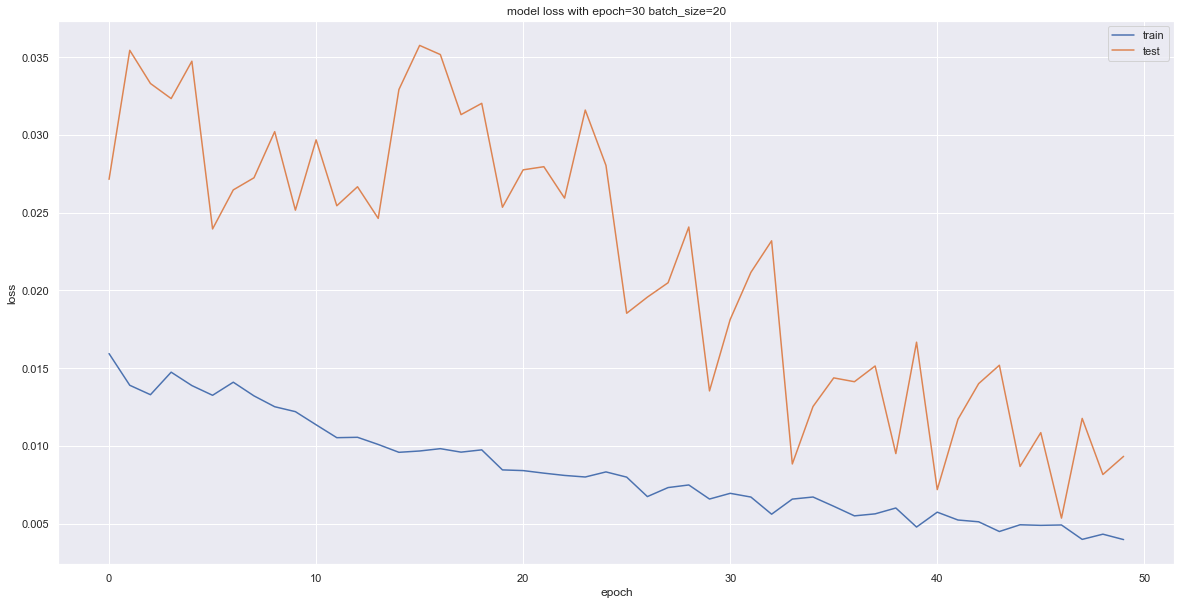

In [192]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with epoch=30 batch_size=20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [193]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = lstm_model_new.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.009323173687688792 (100,) (100,)
[0.61101276 0.61714774 0.64047503 0.65751195 0.642828   0.629088
 0.6269613  0.6309595  0.64554465 0.6633191  0.64854324 0.61714774
 0.61714774 0.63766897 0.6811006 ]
[0.69764726 0.71148665 0.70063367 0.71250638 0.76298342 0.73355671
 0.71673103 0.70252743 0.71476436 0.71658532 0.72554443 0.73494066
 0.75518976 0.76487729 0.76735377]


In [194]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[174.22595 175.0682  178.27081 180.60982 178.59386 176.70749 176.41553
 176.96443 178.96683 181.40707 179.37851 175.0682  175.0682  177.88557
 183.8483 ]
[186.11999512 188.02000427 186.52999878 188.16000366 195.08999634
 191.05000305 188.74000549 186.78999329 188.47000122 188.72000122
 189.94999695 191.24000549 194.02000427 195.3500061  195.69000244]


Error is 0.009323173687688792 (100,) (100,)


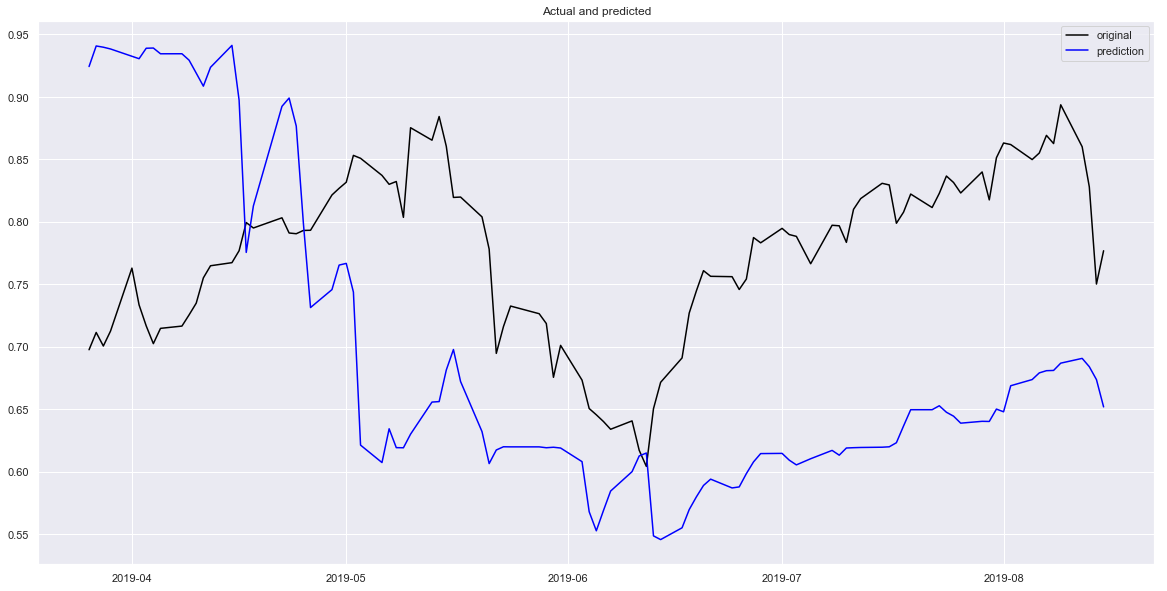

In [205]:
#visualize the prediction result on test set

predicted = y_pred
original = y_test_t
error = mean_squared_error(original, predicted)
print("Error is", error, original.shape, predicted.shape)
Date_test=pd.to_datetime(Date_test.date)[-len(predicted):]
plt.title('Actual and predicted')
plt.plot(Date_test,original, color='black', label = 'Original data')
plt.plot(Date_test,pred, color='blue', label = 'Predicted data')
plt.legend(['original', 'prediction'],loc='best')
plt.show()

### Classification model on testing set

In [196]:
#create set for signal classifier, again
y_t_sig=turn_to_signal(y_t)[1]
y_test_sig=turn_to_signal(y_test_t)[1]
print(sum(y_t_sig))


[272. 323. 224.]


In [197]:

x_sig_test=x_test_t[0:len(x_test_t)-1]
nsamples1, nx1, ny1 = x_sig_test.shape
print(x_sig_test.shape)
print(y_test_sig.shape)
x_sig_t=x_t[0:len(x_t)-1]
nsamples, nx, ny = x_sig_t.shape
x_sig_t =x_sig_t.reshape((nsamples,nx*ny))

x_sig_test=x_test_t[0:len(x_test_t)-1]
nsamples1, nx1, ny1 = x_sig_test.shape
x_sig_test =x_sig_test.reshape((nsamples1,nx1*ny1))
random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel='poly', probability=True,
                                 random_state=random_state))# kernel must be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
y_pre = classifier.fit(x_sig_t, y_t_sig).decision_function(x_sig_test)

(99, 30, 5)
(99, 3)


C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


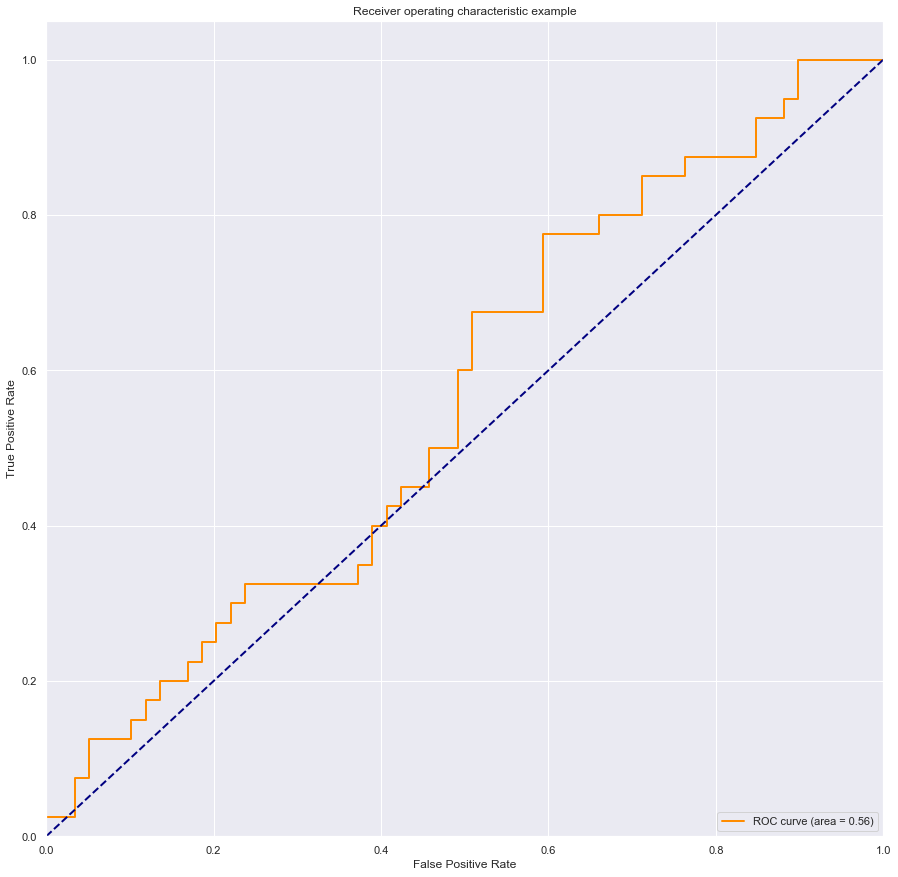

In [199]:

class_pre=y_pre.argmax(axis=1)
class_org=y_test_sig.argmax(axis=1)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_sig[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_sig.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(15,15))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[10 18 16]
 [ 3  9  6]
 [ 7 12 18]]
Normalized confusion matrix
[[0.22727273 0.40909091 0.36363636]
 [0.16666667 0.5        0.33333333]
 [0.18918919 0.32432432 0.48648649]]


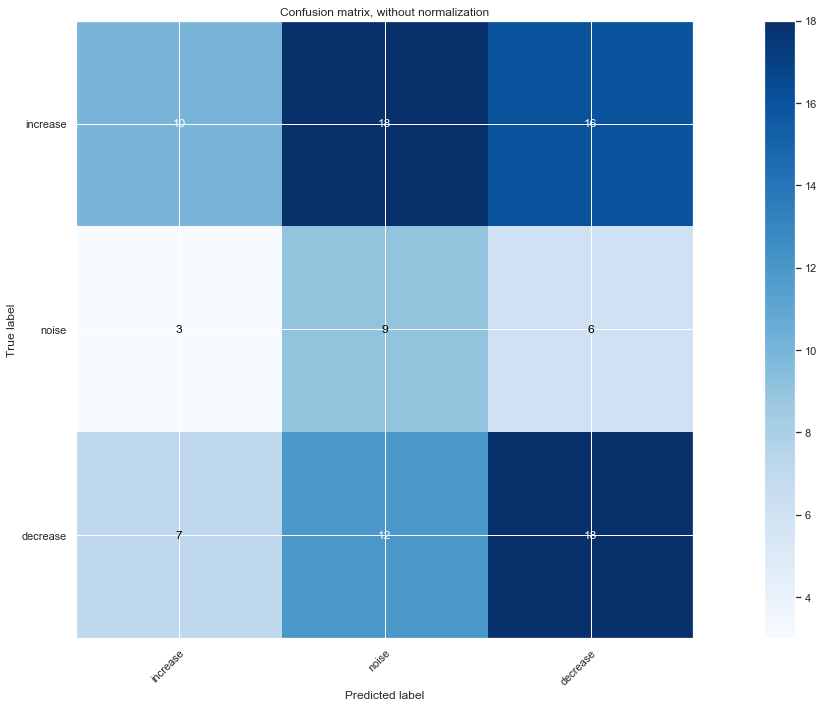

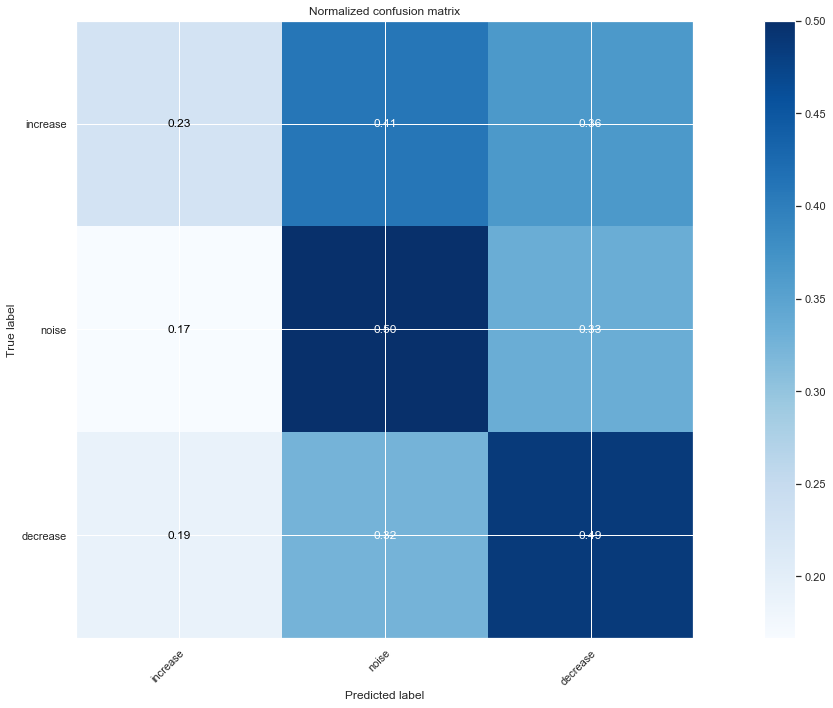

In [200]:
class_names=np.array(['increase', 'noise', 'decrease'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### From the confusion matrix, we could see, the ROC rate on testing set was not satisfied enough. But the impact of the model on predicting the downturn of the price was not bad.

# Conclusion
## LSTM for price prediction
Pros:<br>
The MSE value of the sclaed price prediction on both Vlaidation(0.0086) set and testing(0.0093) set was small and the model can generally catch the price pattern.<br>
Cons:<br>
Because of leading days, obvious lagging was shown in prediction.
## LSTM for price trend classification
Cons:<br>
All the predicted probabilities were predicted around a constant, which made it hard for model to distinguish up-turn and down-turn signals.
## SVM for price trend classification
Pros:<br>
From the ROC curve, the model was shown positive impact in prediction. 
<br>
Cons:<br>
From the confusion matrix, the model has relatively false positive rate, which may lead to loss in investment.

# Section 2: Decision Trees
By Reon Ho
There have been many studies and publications using decision trees for time series or stock signal predicition. Some of these papers have yielded very impressive results especially for signal predictions. The idea here is that a decision tree emulates the natural thought process of a human trader, i.e. making trades based on whether certain conditions have been met for that ticker.

This part will explore the intuition behind decision trees before training our own classification trees for the AAPL data set.



### Contents:
0. Background 
1. Data Exploration
2. Feature Engineering
3. Training Classification Trees
4. Training Regression Tree

## Background


### Classification Trees

The decision tree algorithm aims to recursively split the data points in the training set until the data points are completely separated or well separated. At each iteration, the tree splits the datasets by the feature(s) that give the maximum reduction in heterogeneity, which is calculated by a heterogeneity index.

Below is a binary decision tree that has been split for a few iterations.

![image.png](https://elf11.github.io/images/decisionTree.png)

For the problem of signal prediction, the target is a binary signal (signal = up or down). Therefore, we will be building a binary decision tree, using the the GINI Index as the Heterogeneity index. The GINI is given by:

![image.png](https://miro.medium.com/max/664/1*otdoiyIwxJI-UV0ukkyutw.png)

The GINI index measures how heterogenous a single node is (0 being completely homogenous and 1 being heterogenous). For each possible split, we will calculate the *weighted sum* of the GINI indices of the child nodes, and choose the split that results in the maximum information gain. i.e. reduction in the weighted sum of the GINI Index.

### Ensembling
Ensembling means we train multiple trees and aggregate the results from all our trees to make a decision.

#### Random Forest

Random Forest is an ensemble method for the decision tree algorithm. It works by randomly choosing different features and data points to train multiple trees (that is, to form a forest) - and the resulting prediction is decided by the votes from all the trees. 

Decision Trees are prone to overfitting on the training data, which reduces the performance on the test set. Random Forest mitigates this by training multiple trees. Random Forest is a form of bagging ensemble where the trees are trained concurrently. 

#### Gradient Boosting Trees (xgBoost)
xgBoost is short for "Extreme Gradient Boosting". It is a boosting ensemble method for decision trees. This means that the trees are trained consecutively, where each new tree added is trained to correct the error from the previous tree.

xgBoost uses the gradient descent algorithm at each iteration to maximise the reduction in the error term. 

### Regression Trees
Regression trees operate on a similar principle. Instead of splitting the datapoints into different groups based on their class, we split the data points into different groups by minimising the Sum of Squared errors in each child node at each split.

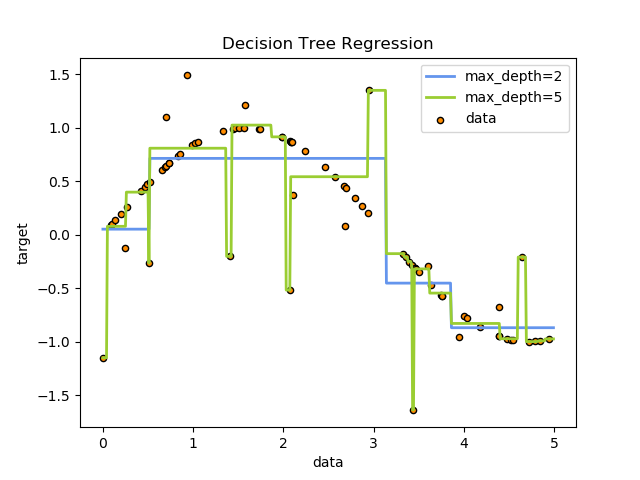

## Packages

In [1]:
from sklearn.ensemble import *
from sklearn.metrics import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ta import *

## Data Exploration

In [3]:
# This is from Samuel's part
df = pd.read_csv('AAPL.csv') #Read the data in
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d') #Set the date column to datetime
#df.set_index('Date', inplace=True) #Set the index to the date column
df = df.rename(columns = {'Adj Close':'Adj_Close'})
df = df.rename(columns = {'Date':'Timestamp'})
df.head(5) #Observe a few rows of data

,Timestamp,Open,High,Low,Close,Adj_Close,Volume
0,2000-08-31,4.212054,4.392857,4.209821,4.352679,3.798641,104899200
1,2000-09-01,4.379464,4.544643,4.366071,4.531250,3.954481,64218000
2,2000-09-05,4.475446,4.580357,4.446429,4.459821,3.892146,74660600
3,2000-09-06,4.383929,4.455357,4.125000,4.174107,3.642799,88851000
4,2000-09-07,4.223214,4.468750,4.160714,4.428571,3.864874,54366200


In [4]:
#Target - next day price
target =  list(df["Adj_Close"])[3:] + [0,0,0]
#df["Target"] = target
df["Binary_Target"] = target > df["Adj_Close"]
df = df.drop("Close", axis = 1)
df["Close"] = df["Adj_Close"]
df.head()

,Timestamp,Open,High,Low,Adj_Close,Volume,Binary_Target,Close
0,2000-08-31,4.212054,4.392857,4.209821,3.798641,104899200,False,3.798641
1,2000-09-01,4.379464,4.544643,4.366071,3.954481,64218000,False,3.954481
2,2000-09-05,4.475446,4.580357,4.446429,3.892146,74660600,False,3.892146
3,2000-09-06,4.383929,4.455357,4.125000,3.642799,88851000,False,3.642799
4,2000-09-07,4.223214,4.468750,4.160714,3.864874,54366200,False,3.864874


## Feature Engineering

In this section we will be creating technical indicators that are commonly used for stock technical analysis. We use the package "ta" to create the technical indicators. To remain consistent with the other models, we will only use features engineered from the time series data. As we will observe later, this is a major limitation to our decision treees model.

### Indicators:

#### Volume
1. Accumulation/Distribution Index (ADI)
2. On-Balance Volume (OBV)
3. Chaikin Money Flow (CMF)
4. Force Index (FI)
5. Ease of Movement (EoM, EMV)
6. Volume-price Trend (VPT)
7. Negative Volume Index (NVI)

#### Volatility
1. Average True Range (ATR)
2. Bollinger Bands (BB)
3. Keltner Channel (KC)
4. Donchian Channel (DC)

#### Trend
1. Moving Average Convergence Divergence (MACD)
2. Average Directional Movement Index (ADX)
3. Vortex Indicator (VI)
4. Trix (TRIX)
5. Mass Index (MI)
6. Commodity Channel Index (CCI)
7. Detrended Price Oscillator (DPO)
8. KST Oscillator (KST)
9. Ichimoku Kinkō Hyō (Ichimoku)

#### Momentum
1. Money Flow Index (MFI)
2. Relative Strength Index (RSI)
3. True strength index (TSI)
4. Ultimate Oscillator (UO)
5. Stochastic Oscillator (SR)
6. Williams %R (WR)
7. Awesome Oscillator (AO)
8. Kaufman's Adaptive Moving Average (KAMA)

#### Others
1. Daily Return (DR)
2. Daily Log Return (DLR)
3. Cumulative Return (CR)
4. 3 day moving Average

For a start, we simply add every single indicator into our dataset. The decision tree algorithm includes embedded feature selection, which means the model will conduct feature selection automatically during the training phase.


In [5]:
def sma(n, ts):
    return ts.rolling(window=n).mean()

In [6]:
df= add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)
df["3sma"] = sma(3,df["Close"])
df["50sma"] = sma(50,df["Close"])
df = df.dropna()
df.head(15)

C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:176: RuntimeWarning: invalid value encountered in subtract
  dx = 100 * np.abs((dip - din) / (dip + din))


,Timestamp,Open,High,Low,Adj_Close,Volume,Binary_Target,Close,volume_adi,volume_obv,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,3sma,50sma
49,2000-11-09,1.419643,1.464286,1.361607,1.258421,119208600,True,1.258421,-7.635159e+08,-3.225761e+09,...,1.145117,2.143528,7.432730,-97.856472,-0.253545,0.623046,0.621114,-66.871810,1.279200,2.215114
50,2000-11-10,1.382813,1.419643,1.361607,1.188292,105562800,True,1.188292,-1.094858e+09,-3.331324e+09,...,-4.343012,-15.707497,-4.467953,-115.707497,-0.224317,-5.572777,-5.734078,-68.717970,1.232447,2.162907
51,2000-11-13,1.339286,1.428571,1.303571,1.207773,107954000,False,1.207773,-1.009477e+09,-3.223370e+09,...,-7.167479,-10.748695,-8.104221,-110.748695,-0.190520,1.639412,1.626119,-68.205129,1.218162,2.107973
52,2000-11-14,1.424107,1.464286,1.397321,1.262317,102250400,False,1.262317,-7.879543e+08,-3.121119e+09,...,-3.965633,3.135238,-7.773651,-96.864762,-0.144814,4.516080,4.417075,-66.769247,1.219461,2.055376
53,2000-11-15,1.430804,1.441964,1.375000,1.238941,70589400,False,1.238941,-8.719716e+08,-3.191709e+09,...,-3.335379,-10.338158,-5.983872,-110.338158,-0.092109,-1.851833,-1.869194,-67.384625,1.236344,2.007299
54,2000-11-16,1.392857,1.415179,1.348214,1.184396,59843000,False,1.184396,-7.100733e+08,-3.251552e+09,...,-5.892147,-35.125234,-14.109385,-135.125234,-0.081880,-4.402550,-4.502404,-68.820533,1.228551,1.953689
55,2000-11-17,1.370536,1.375000,1.303571,1.153228,111545000,False,1.153228,-9.337360e+08,-3.363097e+09,...,-4.707452,-44.311584,-29.924992,-144.311584,-0.078755,-2.631552,-2.666797,-69.641037,1.192188,1.903352
56,2000-11-20,1.328125,1.392857,1.303571,1.180500,102016600,True,1.180500,-9.643565e+08,-3.261080e+09,...,-3.529126,-36.273527,-38.570115,-136.273527,-0.072413,2.364840,2.337311,-68.923096,1.172708,1.854106
57,2000-11-21,1.370536,1.392857,1.339286,1.172708,75488000,False,1.172708,-9.281991e+08,-3.336568e+09,...,-1.727826,-38.570115,-39.718409,-138.570115,-0.077613,-0.660059,-0.662247,-69.128222,1.168812,1.805562
58,2000-11-22,1.343750,1.366071,1.312500,1.153228,70133000,False,1.153228,-1.032103e+09,-3.406701e+09,...,-4.938473,-44.311584,-39.718409,-144.311584,-0.081999,-1.661113,-1.675064,-69.641037,1.168812,1.756316


In [7]:
#Shape of the dataframe
print("There are " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " features")

There are 4730 rows and 68 features


## Classification Tree Training

In [8]:
np.random.seed(1997) #make results reproducible

In [9]:
# Split into independent and dependent variables
df = df[df["Timestamp"] > '2015-09-01']
X = df.copy().drop('Binary_Target', axis =1)
y = df[['Timestamp','Binary_Target']]

# Get Training set
X_train = X[X["Timestamp"] <= '2018-08-31']
y_train = y[y["Timestamp"] <= '2018-08-31']

X_test = X[X["Timestamp"] > '2018-08-31']
y_test = y[y["Timestamp"] > '2018-08-31']

In [10]:
#Test set
X_test.set_index('Timestamp', inplace=True) #Set the index to the date column
y_test.set_index('Timestamp', inplace=True) #Set the index to the date column

In [11]:
X_train.set_index('Timestamp', inplace=True) #Set the index to the date column
y_train.set_index('Timestamp', inplace=True) #Set the index to the date column
y_train = np.ravel(y_train)

In [12]:
def get_roc(model, y_test, X_test, name):
    fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
    tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + name)
    plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % (auc(fpr, tpr)))
    plt.legend(loc="lower right")
    plt.show()

## Iteration 0 (All Features, Single Decision Tree)
For the zeroth iteration, no featue selection will be conducted. Instead, the decision tree algorithm automatically does feature selection for us by picking features that best split the data. In this case, we use the GINI Index to calculate our information gain.

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
clf0 = DecisionTreeClassifier(min_samples_split = 5)
clf0.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
print(classification_report(y_test["Binary_Target"], clf0.predict(X_test)))

              precision    recall  f1-score   support

       False       0.51      0.53      0.52       113
        True       0.60      0.58      0.59       137

    accuracy                           0.56       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.56      0.56      0.56       250



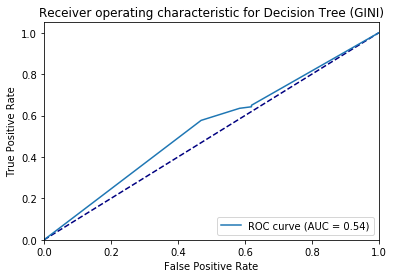

In [16]:
get_roc(clf0, y_test, X_test, "Decision Tree (GINI)")

The results show that the lone decision tree performs slightly better than random chance (the baseline ROC). 

Of interest is the recall value for "True" and "False" signals. For example, A 60% recall means that our model is able to detect ~60% of all trading days that will result in losses. The recalls here are both greater than 50% which is a good result.

Although this is not a remarkable result it is still promising and we will explore further with ensembles.

## Iteration 1 (All Features, Random Forest)
For this first iteration, no featue selection will be conducted too. Instead, the Random Forest algorithm randomly selects features for each tree, which does the feature selection by picking features that best split the data. Again, we use the GINI Index to calculate our information gain.

In [17]:
clf = RandomForestClassifier(n_estimators=100, bootstrap = "False" ,min_samples_split = 5)

In [18]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap='False', class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
predicted = clf.predict(X_test)

In [20]:
pd.crosstab(y_test["Binary_Target"],predicted, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True
Actual,,
False,10,103
True,19,118


In [21]:
print(classification_report(y_test["Binary_Target"], predicted))

              precision    recall  f1-score   support

       False       0.34      0.09      0.14       113
        True       0.53      0.86      0.66       137

    accuracy                           0.51       250
   macro avg       0.44      0.47      0.40       250
weighted avg       0.45      0.51      0.42       250



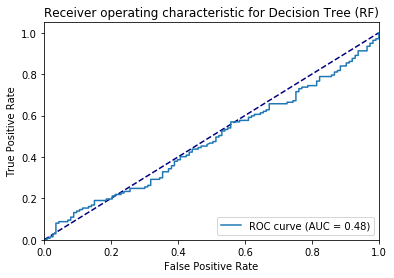

In [22]:
get_roc(clf, y_test, X_test, "Decision Tree (RF)")

Our model accuracy is pretty bad -  note that since this is a binary classification problem, the nearer the accuracy is to 50%, the worse the model is. What is more worrying is the recall for True has increased significantly whereas that for False is almost zero. The random forest model performs worse than our original since it is unable to detect loss-making days, and seems to predict that prices will go up for all days.

## Iteration 2 (xgBoost, all 31 features)

In [23]:
xgb_clf = GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, min_samples_split = 5).fit(X_train, y_train)

In [24]:
predicted_xgb = xgb_clf.predict(X_test)

In [25]:
pd.crosstab(y_test["Binary_Target"],predicted_xgb, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True
Actual,,
False,25,88
True,26,111


In [26]:
print(classification_report(y_test["Binary_Target"], predicted_xgb))

              precision    recall  f1-score   support

       False       0.49      0.22      0.30       113
        True       0.56      0.81      0.66       137

    accuracy                           0.54       250
   macro avg       0.52      0.52      0.48       250
weighted avg       0.53      0.54      0.50       250



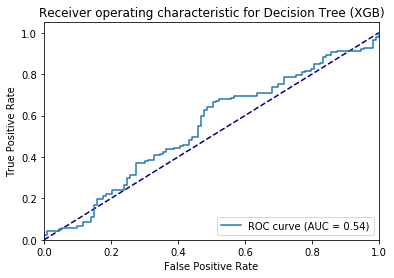

In [27]:
get_roc(xgb_clf, y_test, X_test, "Decision Tree (XGB)")

The xgBoost model performs better than random forest in terms of accuracy. And has a larger AUC which implies a better fit for the data. The recall on "False" is again very low. This is worrying since our model cannot detect loss making days and this model would also be dangerous to deploy. 

## Iteration 3 (Random Forest, with feature selection for top 17 features)


In this part, we will attempt to do some preliminary feature selection to reduce noise in the training phase. We select an arbitrary number of features to feed into the mode. In this case, we chose k=17 features (a quarter the number of original features (66))

In [28]:
from sklearn.feature_selection import *

In [29]:
k = 17
X_test_kbest = pd.DataFrame(SelectKBest(f_classif, k=k).fit(X_train, y_train).transform(X_test))
X_train_kbest = pd.DataFrame(SelectKBest(f_classif, k=k).fit(X_train, y_train).transform(X_train))

C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [22 33 34 35] are constant.
  UserWarning)
C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [22 33 34 35] are constant.
  UserWarning)
C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [30]:
X_test_kbest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-7.018517e+07,588591.060150,5.942630,0.0,7.104949,6.364544,0.740405,0.313324,0.421885,0.468248,164.637414,116.707855,115.295443,100.0,96.0,39.646182,17.172351
1,7.489134e+06,-129650.983236,5.860978,0.0,7.106146,6.512864,0.593282,0.333101,0.403485,0.476275,136.004583,116.694393,115.634555,96.0,92.0,40.458400,17.629235
2,-3.573869e+07,-787298.698392,5.874480,0.0,6.729959,6.556283,0.173676,0.427820,0.276444,0.477854,83.491427,115.690799,115.882929,92.0,76.0,40.319364,17.227617
3,-2.351251e+07,-873330.138727,5.860524,0.0,6.217135,6.488454,-0.271319,0.513419,0.180314,0.472384,57.599319,113.696129,115.869700,88.0,76.0,39.786549,15.836089
4,-2.454962e+07,-833866.289618,5.826201,0.0,5.511194,6.293002,-0.781808,0.584924,0.045042,0.458715,5.925027,109.694724,115.361657,84.0,76.0,38.645028,13.345796


In [31]:
X_train_kbest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-2.218388e+06,-7.804098e+05,9.780443,0.0,-2.533268,-2.919766,0.386498,0.472254,0.063654,-0.396304,-27.695586,-90.582567,-89.457481,4.0,-68.0,-17.692531,-5.571325
1,-5.839715e+07,1.720834e+06,9.648624,0.0,-2.421515,-2.820116,0.398601,0.474710,0.049778,-0.386181,-26.959246,-89.001206,-90.442538,4.0,-64.0,-17.357702,-5.099001
2,3.407425e+07,-1.431804e+06,9.491118,0.0,-2.388258,-2.733744,0.345486,0.507114,0.099759,-0.376719,-54.725050,-84.774379,-90.039443,24.0,-40.0,-17.217389,-5.030501
3,2.914475e+06,1.027517e+06,9.568907,0.0,-2.108658,-2.608727,0.500069,0.487091,0.071795,-0.362330,-0.361245,-78.388550,-88.584642,20.0,-40.0,-16.521244,-4.801972
4,2.875702e+07,-1.091654e+05,9.542770,0.0,-2.026379,-2.492257,0.465878,0.482388,0.048453,-0.348131,-4.889481,-73.317385,-86.471932,16.0,-40.0,-16.204549,-3.998442


In [32]:
clf3 = RandomForestClassifier(n_estimators=200, random_state=0)
clf3.fit(X_train_kbest, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
predicted3 = clf3.predict(X_test_kbest)

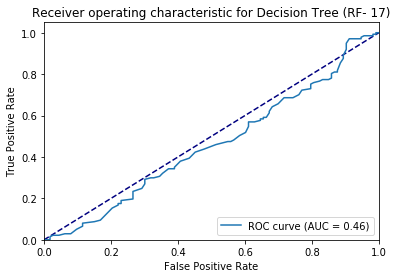

In [34]:
get_roc(clf3, y_test, X_test_kbest, "Decision Tree (RF- 17)")

In [35]:
print(classification_report(y_test["Binary_Target"], predicted3))

              precision    recall  f1-score   support

       False       0.42      0.29      0.35       113
        True       0.53      0.67      0.60       137

    accuracy                           0.50       250
   macro avg       0.48      0.48      0.47       250
weighted avg       0.48      0.50      0.48       250



## Iteration 4 (xgboost, feature selection)

In [36]:
xgb_clf2 = GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, min_samples_split = 5).fit(X_train_kbest , y_train)

In [37]:
predicted_xgb2 = xgb_clf2.predict(X_test_kbest)

In [38]:
print(classification_report(y_test["Binary_Target"], predicted_xgb2))

              precision    recall  f1-score   support

       False       0.59      0.30      0.40       113
        True       0.59      0.82      0.69       137

    accuracy                           0.59       250
   macro avg       0.59      0.56      0.54       250
weighted avg       0.59      0.59      0.56       250



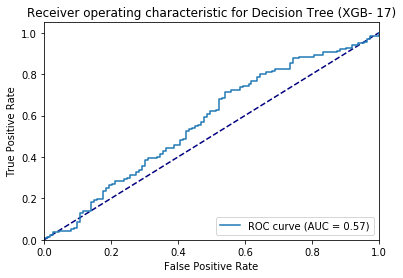

In [39]:
get_roc(xgb_clf2, y_test, X_test_kbest, "Decision Tree (XGB- 17)")

We can observe that XGBoost benefited from the feature selection, since it is prone to overfitting. Random Forest however, did not improve with feature selection since the algorithm includes randomly selecting features. The less features to select, the less trees in the forest and the worse the model performs.


## Conclusion - Signal Processing
In conclusion, decision trees show some promise in predicitng stock prices, with accuracies that are slightly better than random chance. 

As mentioned earlier, the limitation of our model includes the fact that all our features are combinations of the OHLC Data. A better decision tree model will definitely need to account for external indicators like news headlines, market performance of other stocks, fundamental ratios of the underlying company (AAPL) and so on. In reality, traders rarely make trades based on TA of a single stock in isolation so our Decision tree has not been able to perform as well in that regard. 


## Regresson Tree Training
We will now train a regression tree for price prediction. 

In [40]:
target = pd.DataFrame(list(X_train["Adj_Close"])[3:] + 3*[None]).dropna()
target_test = pd.DataFrame(list(X_test["Adj_Close"])[3:] + 3*[None]).dropna()
#df = df.drop("Binary_Target",axis =1)

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

### Iteration 0: Lone Regression Tree

In [42]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train[3:],target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

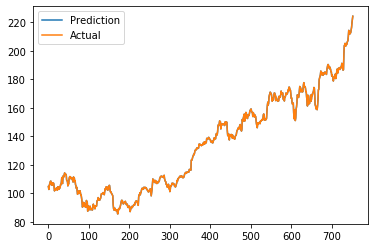

In [43]:
plt.figure()
plt.plot(regressor.predict(X_train[3:]))
plt.plot(target)
plt.legend(['Prediction', 'Actual'], loc='best')

The two lines are almost identical. Training accuracy is pretty good (as to be expected from a decision tree). Now for predictions on the test set.

In [44]:
y_pred = regressor.predict(X_test[3:])
r2_score(target_test, y_pred)

0.8944257541923192

The R2 is 78.9%, which means our model can account for 78.9% of the variation in AAPL stock prices. This is a good sign.

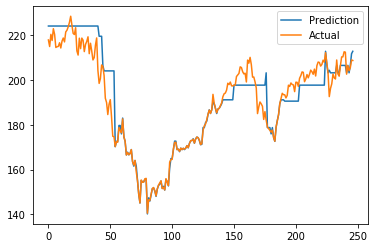

In [45]:
plt.figure()
plt.plot(y_pred)
plt.plot(target_test)
plt.legend(['Prediction', 'Actual'], loc='best')

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
mean_squared_error(target_test, y_pred)

45.737415559504754

### Gradient Boosted Regressor 
Since our RF performed very badly in the signal predictions case, we will be skipping to gradient boosted regression. Gradient Boosted trees performed the best for signal prediction with k = 17. We will try these parameters for our boosted regression tree first.

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

In [49]:
gb_rgr = GradientBoostingRegressor()

In [50]:
gb_rgr.fit(X_train_kbest[3:], np.ravel(target))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

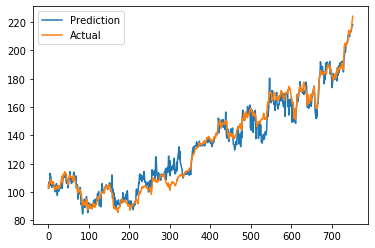

In [51]:
plt.figure()
plt.plot(gb_rgr.predict(X_train_kbest[3:]))
plt.plot(target)
plt.legend(['Prediction', 'Actual'], loc='best')

The prediction on training set is not as accurate as a lone decision tree. This can be a good sign that the model has not been overfitted - we will see.

In [52]:
xgb_pred = gb_rgr.predict(X_test_kbest[3:])
r2_score(target_test, xgb_pred)

-0.566585284802614

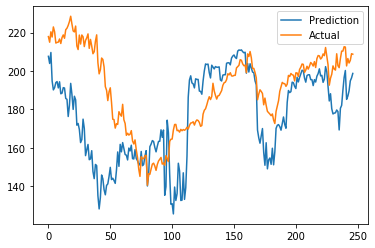

In [53]:
plt.figure()
plt.plot(xgb_pred)
plt.plot(target_test)
plt.legend(['Prediction', 'Actual'], loc='best')

In [54]:
mean_squared_error(target_test, xgb_pred)

678.6841017168734

The performance is abysmal for Gradient Boosted Trees with 17 features. Trying again with all features:

In [55]:
gb_rgr2 = GradientBoostingRegressor()
gb_rgr2.fit(X_train[3:], np.ravel(target))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

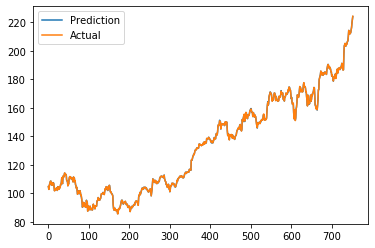

In [56]:
plt.figure()
plt.plot(gb_rgr2.predict(X_train[3:]))
plt.plot(target)
plt.legend(['Prediction', 'Actual'], loc='best')

In [58]:
xgb_pred2 = gb_rgr2.predict(X_test[3:])
r2_score(target_test, xgb_pred2)

0.9635292264400017

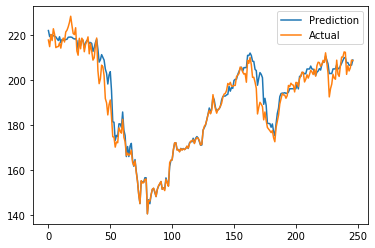

In [59]:
plt.figure()
plt.plot(xgb_pred2)
plt.plot(target_test)
plt.legend(['Prediction', 'Actual'], loc='best')

In [60]:
mean_squared_error(target_test, xgb_pred2)

15.800055338580325

Impressive results! Our gradient boosted regressor with all features has managed to perform very very well with an R^2 of 0.96773!

## Conclusion - Regression
In conclusion, regression trees perform very well for price prediction. We are however limited by the fact that the model we trained only forecasts 3 days into the future. Application for regression trees is also not as clear as for signal prediction (buy or sell).

The results for decision trees are below for comparison with Prophet and LSTM.

In [61]:
model = ["Lone Tree", "RF", "XGB", "RF-17", "XGB-17"]
acc = [0.56, 0.51, 0.54, 0.50, 0.59]
ROC = [0.54, 0.48, 0.54, 0.46, 0.57]
rsq = [0.789, None, 0.964, None,0.578]
mse = [91.4, None,15.8, None, 683]

res = pd.DataFrame([acc, ROC, rsq, mse])
res.columns = model
res.index = ["Acc", "ROC", "Rsquare", "MSE"]
res

,Lone Tree,RF,XGB,RF-17,XGB-17
Acc,0.560,0.51,0.540,0.50,0.590
ROC,0.540,0.48,0.540,0.46,0.570
Rsquare,0.789,NaN,0.964,NaN,0.578
MSE,91.400,NaN,15.800,NaN,683.000


# Section 3: Prophet Model
By Samuel Khoo

For this project, I aim to follow the intended approach of the Prophet model - the analyst-in-the-loop modeling approach. 

Prophet is a modular regression model with interpretable parameters that can be intuitively adjusted by analysts with domain knowledge about the time series. This approach attempts to blend the advantages of statistical and judgement forecasts by codifying the human domain knowledge in an improved model after some iteration. This allows analysts to apply judgement to forecasts through a small set of intuitive parameters and options, while retaining the ability to fall back on fully automated statistical forecasting when necessary.

Most financial analysts have extensive domain knowledge about the product they are in charge of, but have limited statistical knowledge. On the other hand, broad statistical forecasts do not account for such domain knowledge. Hence, I aim to evaluate if, in the algo-trading context, will analyst-in-the-loop modeling approach would be able to improve returns.

As such, the structure of the notebook is rather different from that of a normal ML project notebook, which showcases only the final version of the model. Instead, I will run through the different iterations which I hope will simulate the thought process of an analyst.

![image.png](https://miro.medium.com/max/3064/1*V6BphWM72PzQ2cLbiIzLwQ.png)

### Table of Contents
1. Exploratory Data Analysis
2. Iteration 1: Using only the time series
3. Iteration 2: Adding Volume as an additional regressor
4. Iteration 3: Adding 3-day Moving Average as an additional regressor

### Import Packages

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
from matplotlib import pyplot

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('AAPL (2).csv') #Read the data in
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y') #Set the date column to datetime
df.set_index('Date', inplace=True) #Set the index to the date column
df = df.rename(columns = {'Adj Close':'Adj_Close'})
df.head(20) #Observe a few rows of data

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2015-09-01,110.150002,111.879997,107.360001,107.720001,100.533249,76845900
2015-09-02,110.230003,112.339996,109.129997,112.339996,104.845024,61888800
2015-09-03,112.489998,112.779999,110.040001,110.370003,103.006447,53233900
2015-09-04,108.970001,110.449997,108.510002,109.269997,101.979836,49996300
2015-09-08,111.750000,112.559998,110.320000,112.309998,104.817017,54843600
2015-09-09,113.760002,114.019997,109.769997,110.150002,102.801125,85010800
2015-09-10,110.269997,113.279999,109.900002,112.570000,105.059677,62892800
2015-09-11,111.790001,114.209999,111.760002,114.209999,106.590263,49915500
2015-09-14,116.580002,116.889999,114.860001,115.309998,107.616867,58363400


### Data Visualisation

In this section, I graph the adjusted close price time series against the volume to determine any seasonality or holidays that may be useful when fine tuning the Prophet model.

Text(0, 0.5, 'Volume')

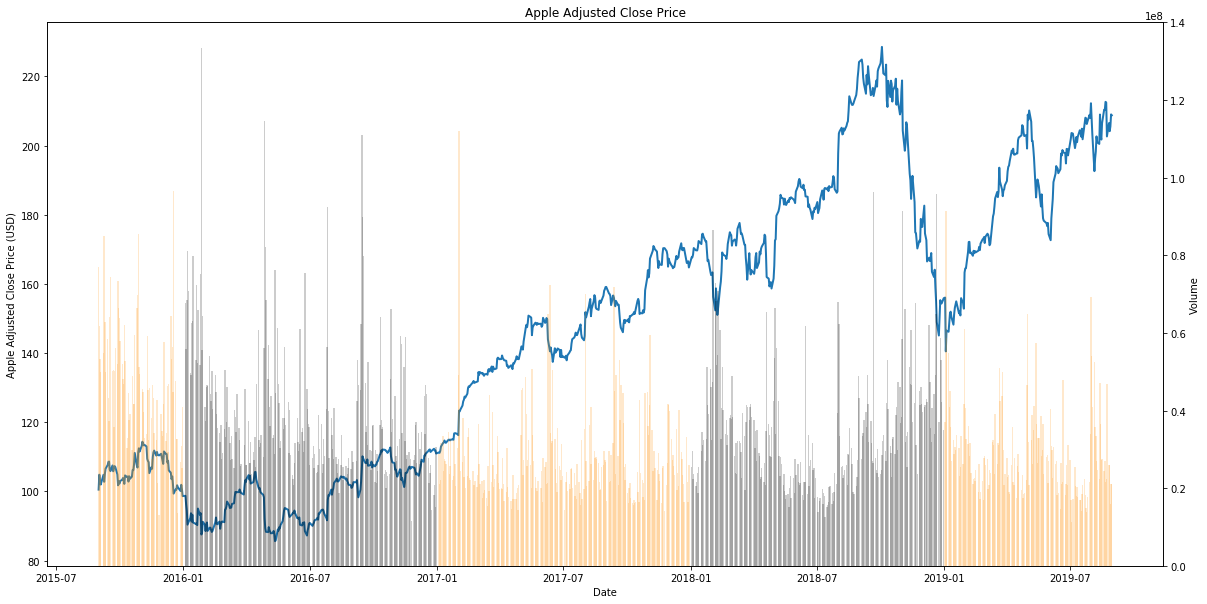

In [3]:
# Split the dataset into the different years
year_2015 = df[(df.index >= '2015-01-01') & (df.index < '2016-01-01')]
year_2016 = df[(df.index >= '2016-01-01') & (df.index < '2017-01-01')]
year_2017 = df[(df.index >= '2017-01-01') & (df.index < '2018-01-01')]
year_2018 = df[(df.index >= '2018-01-01') & (df.index < '2019-01-01')]
year_2019 = df[df.index >= '2019-01-01']

# Build the plot
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(df.Adj_Close, linewidth=2) #plot the Adjusted Close Price on axis 1

# Plot the yearly data as bar plots and changes the color for each year
ax2.bar(year_2015.index, year_2015.Volume,width=2, alpha=0.2, color='darkorange')
ax2.bar(year_2016.index, year_2016.Volume,width=2, alpha=0.2, color='black')
ax2.bar(year_2017.index, year_2017.Volume,width=2, alpha=0.2, color='darkorange')
ax2.bar(year_2018.index, year_2018.Volume,width=2, alpha=0.2, color='black')
ax2.bar(year_2019.index, year_2019.Volume,width=2, alpha=0.2, color='darkorange')
 
ax2.grid(b=False) # turn off grid 2

# Label the graph
ax1.set_title('Apple Adjusted Close Price')
ax1.set_ylabel('Apple Adjusted Close Price (USD)')
ax1.set_xlabel('Date')
ax2.set_ylabel('Volume')

There seems to be a correlation between price fluctuations and volume. When the price fluctuates significantly, there is a spike in volume. We will explore if volume is a good indicator of price changes in one of the iterations below.

## Iteration Evaluation

To compare each iteration fairly, I have standardised the following:
- The model will predict 3 days in advance. This is for practicality as analysts would often have to go through a number of operational processes before executing the trade.
- The iterations will be evaluated based on their R-squared value, Mean Squared Error (MSE) and Mean Absolute Error (MAE).

The Train-Test split is as follows:

- Training Set: 01/09/2015 to 31/08/2018
- Test Set: 01/09/2018 to 30/08/2019 (31/08/2019 is a Saturday)
- There are some missing dates due to weekends and public holidays

## Iteration 1: Using only the time series

In this iteration, I will test the Prophet model straight out of the box. The baseline Prophet model only takes in the time series data which we are trying to predict. Hence, for this iteration, no additional regressors will be supplied.

### Data Preprocessing

In [4]:
# Keep only required variables
y = df[['Adj_Close']]

# Get Training set
y_train = y[y.index <= '2018-08-31']

#Get Test set
y_test = y[y.index > '2018-08-31']

# Preview training set
y_train.head()

,Adj_Close
Date,
2015-09-01,100.533249
2015-09-02,104.845024
2015-09-03,103.006447
2015-09-04,101.979836
2015-09-08,104.817017


As the model aims to predict with a 3 day lead, I will shift the values down by 3 days. At the same time, I will be reformatting the dataframe for the Prophet model.

In [5]:
y_train = y_train.reset_index()
y_train = y_train.rename(columns={'Date':'ds', 'Adj_Close':'y'}) # rename the columns in the Prophet format
y_train['y'] = y_train['y'].shift(3) # push the training set values down by 3 days
y_train = y_train[y_train['ds'] > '2015-09-03'] # remove the NaN values caused by the shift
y_train = y_train.reset_index(drop=True)
y_train.head()

,ds,y
0,2015-09-04,100.533249
1,2015-09-08,104.845024
2,2015-09-09,103.006447
3,2015-09-10,101.979836
4,2015-09-11,104.817017


In [6]:
# create the future dataframe for prophet to predict on
y_test = y_test.reset_index()
y_test = y_test.rename(columns={'Date':'ds', 'Adj_Close':'y'})
future = y_test[['ds']]
future.head()

,ds
0,2018-09-04
1,2018-09-05
2,2018-09-06
3,2018-09-07
4,2018-09-10


### Training and testing the model

In [7]:
m = Prophet() # Initializing the model
m.fit(y_train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
245,2019-08-26,272.899248,219.981463,324.542113
246,2019-08-27,272.889856,220.679362,326.841209
247,2019-08-28,273.100847,220.117576,327.055181
248,2019-08-29,273.470017,220.236312,327.245051
249,2019-08-30,273.758733,221.301949,326.037806


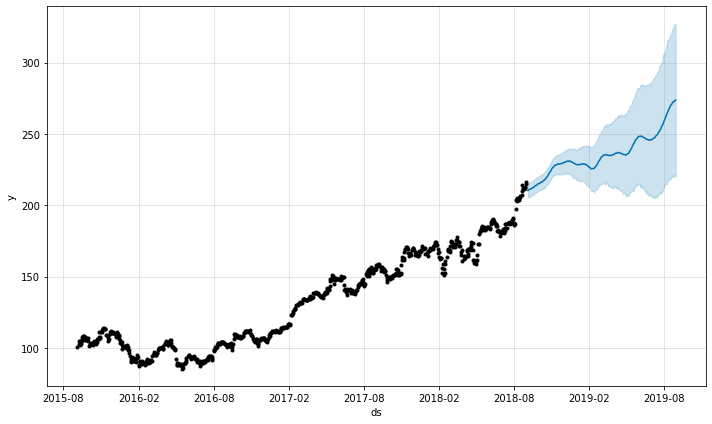

In [9]:
fig1 = m.plot(forecast)

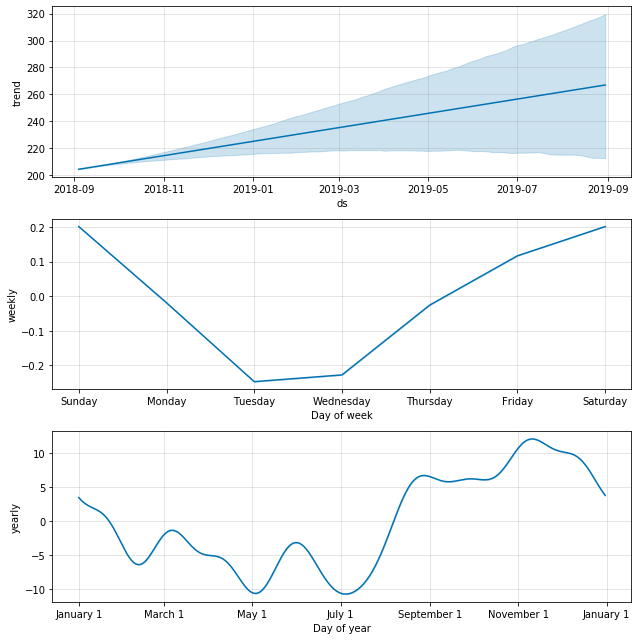

In [10]:
fig2 = m.plot_components(forecast)

### Evaluating the model

In [11]:
# Append the forecasted data to the test data
y_test['yhat'] = forecast['yhat']
y_test.tail()

,ds,y,yhat
245,2019-08-26,206.490005,272.899248
246,2019-08-27,204.160004,272.889856
247,2019-08-28,205.529999,273.100847
248,2019-08-29,209.009995,273.470017
249,2019-08-30,208.740005,273.758733


In [12]:
# Calculate R-squared value
r2_score(y_test['y'], y_test['yhat'])

-5.002520621551185

In [13]:
# Calculate MSE
mean_squared_error(y_test['y'], y_test['yhat'])

2644.0917152007137

In [14]:
# Calculate MAE
mean_absolute_error(y_test['y'], y_test['yhat'])

46.32917374757597

### Iteration 1 Conclusion:

From this iteration, we see that using past time series data alone is insufficient. The model failed to predict the huge drop in the second half of 2018. All three indicators (R-squared, MSE, MAE) performed very badly.

## Iteration 2: Adding Volume as an additional regressor

In this iteration, we will include volume as an additional regressor. From our exploratory data analysis, there seem to be a correlation between volume and price fluctuation. Hence, we would like to test if volume would be a good input for predicting the adjusted close price.

### Data Preprocessing

In [15]:
# Keep only required variables
y2 = df[['Adj_Close', 'Volume']]

# Get Training set
y2_train = y2[y2.index <= '2018-08-31']

#Get Test set
y2_test = y2[y2.index > '2018-08-31']

# Preview training set
y2_train.head()

,Adj_Close,Volume
Date,,
2015-09-01,100.533249,76845900
2015-09-02,104.845024,61888800
2015-09-03,103.006447,53233900
2015-09-04,101.979836,49996300
2015-09-08,104.817017,54843600


Following the previous iteration, I will shift the values down and reformat the dataframe.

In [16]:
y2_train = y2_train.reset_index()
y2_train = y2_train.rename(columns={'Date':'ds', 'Adj_Close':'y'}) # rename the columns in the Prophet format
y2_train['y'] = y2_train['y'].shift(3) # push the training set values down by 3 days
y2_train = y2_train[y2_train['ds'] > '2015-09-03'] # remove the NaN values caused by the shift
y2_train = y2_train.reset_index(drop=True)
y2_train.head()

,ds,y,Volume
0,2015-09-04,100.533249,49996300
1,2015-09-08,104.845024,54843600
2,2015-09-09,103.006447,85010800
3,2015-09-10,101.979836,62892800
4,2015-09-11,104.817017,49915500


In [17]:
# create the future dataframe for prophet to predict on
y2_test = y2_test.reset_index()
y2_test = y2_test.rename(columns={'Date':'ds', 'Adj_Close':'y'})
future2 = y2_test[['ds', 'Volume']]
future2.head()

,ds,Volume
0,2018-09-04,27390100
1,2018-09-05,33333000
2,2018-09-06,34290000
3,2018-09-07,37619800
4,2018-09-10,39516500


### Training and testing the model

In [18]:
m2 = Prophet() # Initialising the model
m2.add_regressor('Volume') # Add the regressor
m2.fit(y2_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
245,2019-08-26,272.686834,222.772111,322.743748
246,2019-08-27,272.729284,223.318449,324.453281
247,2019-08-28,273.434952,223.393977,325.306783
248,2019-08-29,273.548729,223.177996,325.566774
249,2019-08-30,273.961136,223.674407,324.742070


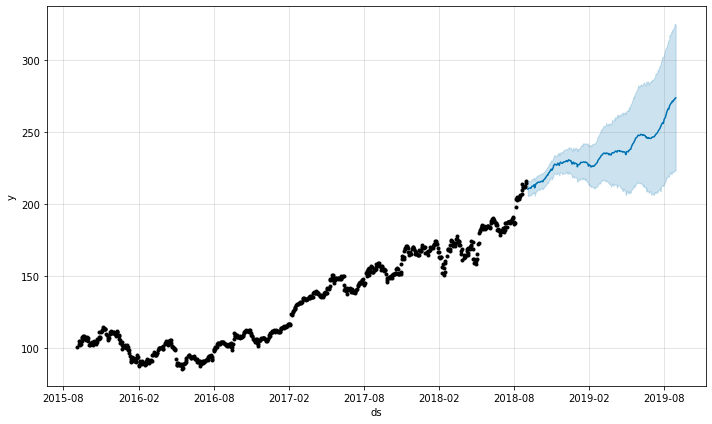

In [20]:
fig1 = m2.plot(forecast2)

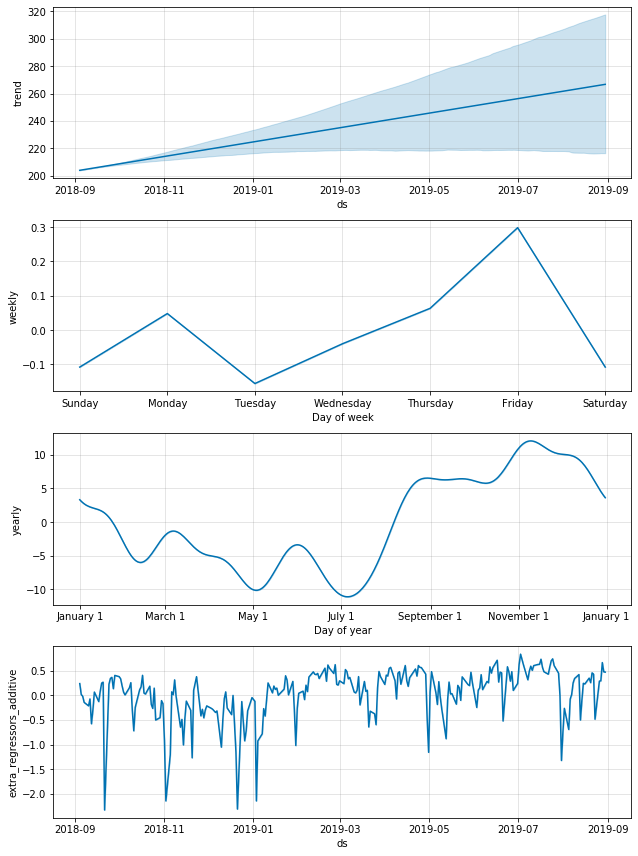

In [21]:
fig2 = m2.plot_components(forecast2)

### Evaluating the model

In [22]:
# Append the forecasted data to the test data
y2_test['yhat'] = forecast2['yhat']
y2_test.tail()

,ds,y,Volume,yhat
245,2019-08-26,206.490005,26043600,272.686834
246,2019-08-27,204.160004,25873300,272.729284
247,2019-08-28,205.529999,15938800,273.434952
248,2019-08-29,209.009995,20990500,273.548729
249,2019-08-30,208.740005,21143400,273.961136


In [23]:
# Calculate R-squared value
r2_score(y2_test['y'], y2_test['yhat'])

-4.981603063557832

In [24]:
# Calculate MSE
mean_squared_error(y2_test['y'], y2_test['yhat'])

2634.8775957866324

In [25]:
# Calculate MAE
mean_absolute_error(y2_test['y'], y2_test['yhat'])

46.25164350764241


### Iteration 2 Conclusion:

Although volume did help improve the indicators slighlty, the general trend of the prediction is still completely off. Hence, using raw time series data does not seem effective for the Prophet model.

## Iteration 3: Adding 3-day Moving Average as an additional regressor

In this iteration, we will include 3 day MA as an additional regressor. The Prophet model allows for the analyst to combine his/her domain knowledge in the product with the statistical prowess of the model. The 3-day Moving Average is a very familiar indicator to most analysts and we would like to see its effect on the model's accuracy.

### Data Preprocessing

In [26]:
# Calculate the 3-day Moving Average
rolling_mean_3 = df.Adj_Close.rolling(window=3).mean()

# Adding the indicator to the dataset
df2 = df.copy()
df2['3_day_MA'] = rolling_mean_3.values
df2.head()

,Open,High,Low,Close,Adj_Close,Volume,3_day_MA
Date,,,,,,,
2015-09-01,110.150002,111.879997,107.360001,107.720001,100.533249,76845900,NaN
2015-09-02,110.230003,112.339996,109.129997,112.339996,104.845024,61888800,NaN
2015-09-03,112.489998,112.779999,110.040001,110.370003,103.006447,53233900,102.794907
2015-09-04,108.970001,110.449997,108.510002,109.269997,101.979836,49996300,103.277102
2015-09-08,111.750000,112.559998,110.320000,112.309998,104.817017,54843600,103.267767


In [27]:
# Keep only required variables
y3 = df2[['Adj_Close', '3_day_MA']]

# Get Training set
y3_train = y3[(y3.index <= '2018-08-31') & ('2015-09-03' <= y2.index)] # to remove NaN values

#Get Test set
y3_test = y3[y3.index > '2018-08-31']

# Preview training set
y3_train.head()

,Adj_Close,3_day_MA
Date,,
2015-09-03,103.006447,102.794907
2015-09-04,101.979836,103.277102
2015-09-08,104.817017,103.267767
2015-09-09,102.801125,103.199326
2015-09-10,105.059677,104.225940


similar to prev iteration...
Since we want to predict w 3 days lead, we will shift the values down. meanwhile getting the format right for prophet

In [28]:
y3_train = y3_train.reset_index()
y3_train = y3_train.rename(columns={'Date':'ds', 'Adj_Close':'y'}) # rename the columns in the Prophet format
y3_train['y'] = y3_train['y'].shift(3) # push the training set values down by 3 days
y3_train['3_day_MA'] = y3_train['3_day_MA'].shift(3)
y3_train = y3_train[y3_train['ds'] > '2015-09-08'] # remove the NaN values caused by the shift
y3_train = y3_train.reset_index(drop=True)
y3_train.head()

,ds,y,3_day_MA
0,2015-09-09,103.006447,102.794907
1,2015-09-10,101.979836,103.277102
2,2015-09-11,104.817017,103.267767
3,2015-09-14,102.801125,103.199326
4,2015-09-15,105.059677,104.225940


In [29]:
# create the future dataframe for prophet to predict on
y3_test = y3_test.reset_index()
y3_test = y3_test.rename(columns={'Date':'ds', 'Adj_Close':'y'})
future3 = y3_test[['ds', '3_day_MA']]
future3.head()

,ds,3_day_MA
0,2018-09-04,223.537847
1,2018-09-05,224.141810
2,2018-09-06,222.654892
3,2018-09-07,220.337530
4,2018-09-10,217.534358


### Training and testing the model

In [30]:
m3 = Prophet() # Initialising the model
m3.add_regressor('3_day_MA') # Add the regressor
m3.fit(y3_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
forecast3 = m3.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
245,2019-08-26,209.216024,207.430078,211.038895
246,2019-08-27,206.212164,204.385905,208.053735
247,2019-08-28,207.205358,205.496128,208.916932
248,2019-08-29,208.209047,206.457488,210.053944
249,2019-08-30,209.708809,207.893865,211.596461


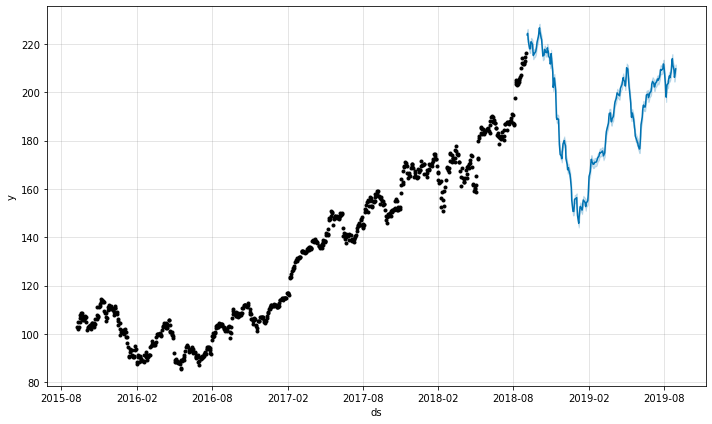

In [32]:
fig1 = m3.plot(forecast3)

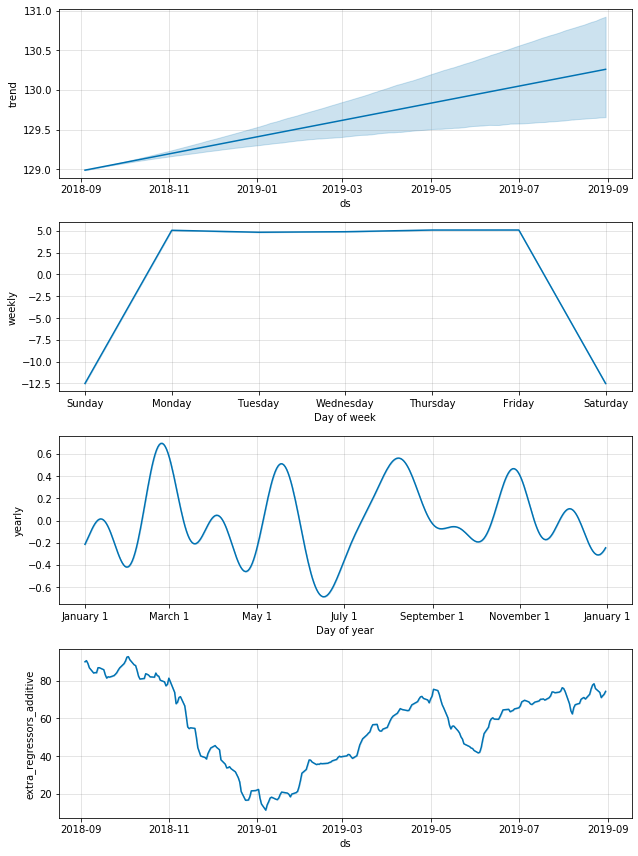

In [33]:
fig2 = m3.plot_components(forecast3)

### Evaluating the model

In [34]:
# Append the forecasted data to the test data
y3_test['yhat'] = forecast3['yhat']
y3_test.tail()

,ds,y,3_day_MA,yhat
245,2019-08-26,206.490005,207.196670,209.216024
246,2019-08-27,204.160004,204.430003,206.212164
247,2019-08-28,205.529999,205.393336,207.205358
248,2019-08-29,209.009995,206.233333,208.209047
249,2019-08-30,208.740005,207.760000,209.708809


In [35]:
# Calculate R-squared value
r2_score(y3_test['y'], y3_test['yhat'])

0.9780932303799027

In [36]:
# Calculate MSE
mean_squared_error(y3_test['y'], y3_test['yhat'])

9.649864067329283

In [37]:
# Calculate MAE
mean_absolute_error(y3_test['y'], y3_test['yhat'])

2.305081128040042

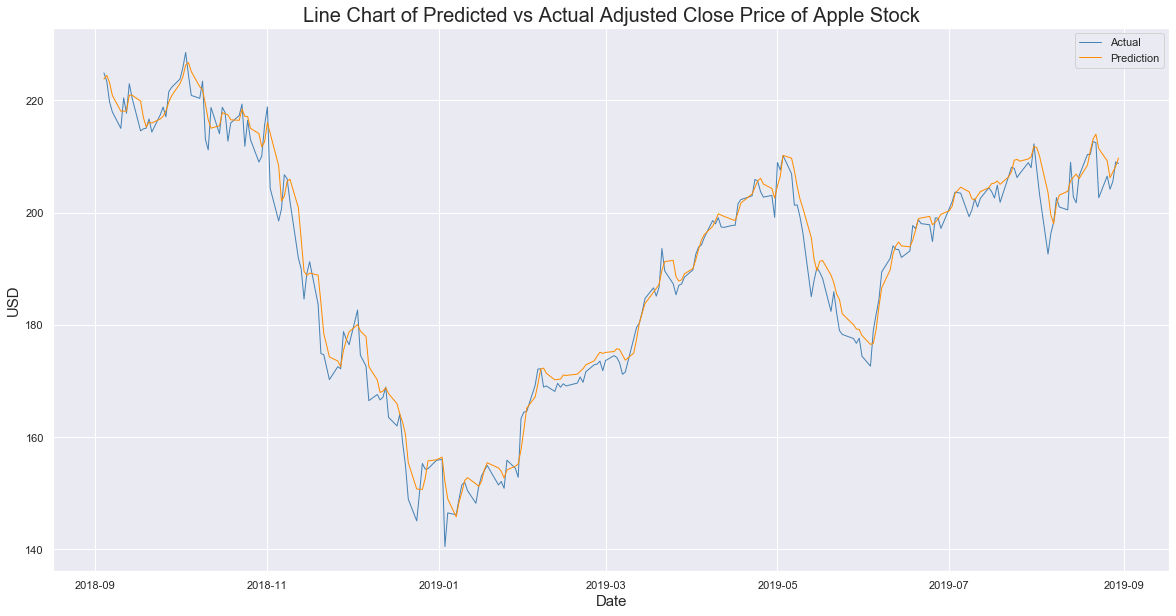

In [40]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})

results = sns.lineplot(x="ds", y="y", data=y3_test, color = 'steelblue', linewidth= 1, label = 'Actual')
results = sns.lineplot(x="ds", y="yhat", data=y3_test, color = 'darkorange', linewidth= 1, label = 'Prediction')
results.axes.set_title("Line Chart of Predicted vs Actual Adjusted Close Price of Apple Stock",fontsize=20)
results.set_xlabel("Date", fontsize=15)
results.set_ylabel("USD", fontsize=15)
results.legend()

pyplot.show()

### Iteration 3 Conclusion:

From this iteration, we see that the 3-day Moving Average significantly boosted the model's performance. The general trend of the prediction follows that of the actual values. Furthermore, the indicators performed very well in this iteration. 

However, on visual inspection, the predictions are lagging. This may be due to the choice of indicator (3 day moving average). Further improvements could be made to use leading indicators instead.

Despite the lagging predictions, it appears that the Prophet model does indeed work better when combined with analyst knowledge.

## Overall Conclusion

Through this 3 iterations, we notice that the analyst in the loop approach is very effective for such problems. Solely using statistical inference to predict Apple's stock price is ineffectively as there may be external factors affecting the price. However, when paired with feedback from the analyst, such as adding the 3 day moving average indicator, the performance of the model greatly improves.

Besides adding regressors, there are many other parameters which an analyst can use to finetune the model. However, for the scope of this project, I will use iteration 3 as the benchmark against the other models. Overall, the Prophet model has delivered positive results and is a very promising model for such problems.

## Model Comparison and Overall Results
 LSTM may not be a good choice for binary classification; the classification impacts of trees and SVM models were both positive and alike(AUROC values were both about 0.56); the outcomes got by models we built for price prediction were generally good according to MSE, however, lagging still existed.